# <center> Модель предсказания отказов компрессора высокого давления

## Импорт библиотек

In [1]:
#Работа с данными
import pandas as pd
import numpy as np

In [2]:
#Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'png' 

#import matplotlib.dates as mdates

#from matplotlib.pylab import rc, plot
#import statsmodels.api as sm

#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

In [3]:
#Подготовка данных, машинное обучение
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
#Метрики качества модели
#from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

## Импорт выборки данных

In [5]:
#data = pd.read_excel(r'D:/users/PMurlykin/JupyterProjects/DAR_task/KVD.XLSX')
data = pd.read_excel(r'KVD.XLSX')
data.head()

DateTime   B3_P_C5    B3_P_C6  B3_P_inKVD1  B3_P_inKVD2  \
0 2019-05-17 09:20:00  5.168750  13.500001     5.082812    13.240625   
1 2019-05-17 09:30:00  5.159375  13.500001     5.082812    13.240625   
2 2019-05-17 09:40:00  5.148125  13.471874     5.082812    13.214062   
3 2019-05-17 09:50:00  5.136875  13.445312     5.056250    13.187499   
4 2019-05-17 10:00:00  5.148125  13.446875     5.056250    13.187499   

   B3_PDIT561  B3_PDIT571  B3_PIT561  B3_PIT563  B3_PIT571  ...  \
0   26.105747  104.541084   5.106489  13.912589  13.340695  ...   
1   26.266880  104.962227   5.090353  13.912589  13.340695  ...   
2   26.058136  104.321358   5.074903  13.885215  13.314511  ...   
3   25.900665  104.586861   5.074903  13.859031  13.288327  ...   
4   26.208286  104.641792   5.074903  13.858436  13.288922  ...   

   B3_Tg_outKVD2  B3_TIT561  B3_TIT571  B3_E_BCL   B3_E_Cm  B3_E_MCL  \
0     108.139999  35.343327  41.644539  0.673587  4.394132  1.696910   
1     108.139999  35.041199  41.598763  0.673587  4.394336  1.697093   
2     108.139999  34.940491  41.642250  0.673815  4.398725  1.699382   
3     108.139999  34.940491  41.740669  0.675830  4.403408  1.699291   
4     108.139999  35.041199  41.939804  0.673815  4.394619  1.697002   

   B3_E_Ras1  B3_E_Ras2     B3_evNKVD  y  
0   2.728573   1.678707  10080.102539  0  
1   2.728573   1.678707  10080.102539  0  
2   2.734113   1.678707  10080.102539  0  
3   2.734113   1.678707  10080.102539  0  
4   2.734113   1.678707  10080.102539  0  

[5 rows x 26 columns]

In [43]:
(data.values[1][0] - data.values[0][0]).seconds

600

In [46]:
(data.values[1][1] - data.values[0][1])/data.values[0][1]

-0.001813803114581664

In [6]:
#Заголовки столбцов параметров
headers = pd.read_excel(r'Описание параметров.XLSX')
headers.head()

field                                description
0       B3_A_SHDT   M6e_A_SHDTIME_RT Таймер останова тек.зн.
1      B3_A_start      M6e_A_F2RENDSEQT Таймер пуска тек.зн.
2     B3_A_TTXD_H  M6e_A_TTXD_H_Предупр-ная уставка Т за ТНД
3    B3_A_TTXD_HH   M6e_A_TTXD_HH_Аварийная уставка Т за ТНД
4  B3_A20AS1_ENUM                 АПР: Состояние АПР (1 ст.)

## Исследование данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13958 entries, 0 to 13957
Data columns (total 26 columns):
DateTime         13958 non-null datetime64[ns]
B3_P_C5          13955 non-null float64
B3_P_C6          13955 non-null float64
B3_P_inKVD1      13951 non-null float64
B3_P_inKVD2      13955 non-null float64
B3_PDIT561       13955 non-null float64
B3_PDIT571       13955 non-null float64
B3_PIT561        13955 non-null float64
B3_PIT563        13955 non-null float64
B3_PIT571        13955 non-null float64
B3_PIT573        13955 non-null float64
B3_T_C5          13955 non-null float64
B3_T_C6          13955 non-null float64
B3_Tg_inKVD1     13955 non-null float64
B3_Tg_inKVD2     13955 non-null float64
B3_Tg_outKVD1    13955 non-null float64
B3_Tg_outKVD2    13955 non-null float64
B3_TIT561        13955 non-null float64
B3_TIT571        13955 non-null float64
B3_E_BCL         13955 non-null float64
B3_E_Cm          13955 non-null float64
B3_E_MCL         13955 non-null float64
B3_E

Вывод:
1. DataFrame состоит из временного ряда, целевой целочисленной переменной и группы показателей (фич) - рациональных чисел.
2. Фичи содержат пропуски значений.

In [8]:
data.describe()

B3_P_C5       B3_P_C6   B3_P_inKVD1   B3_P_inKVD2    B3_PDIT561  \
count  13955.000000  13955.000000  13951.000000  13955.000000  13955.000000   
mean       5.323898     14.039342      5.226354     13.815826     31.678404   
std        0.064942      0.703086      0.061968      0.678627      3.192738   
min        5.053750      7.142188      4.946875      6.974999     19.880066   
25%        5.273750     13.798438      5.181250     13.585938     29.255209   
50%        5.338750     14.160937      5.240625     13.931251     31.445183   
75%        5.362500     14.514062      5.267187     14.267187     33.609524   
max        6.006250     15.390626      5.662500     15.048437     53.747768   

         B3_PDIT571     B3_PIT561     B3_PIT563     B3_PIT571     B3_PIT573  \
count  13955.000000  13955.000000  13955.000000  13955.000000  13955.000000   
mean     104.633832      5.248177     14.423204     13.921211     25.204768   
std       12.838785      0.064652      0.672769      0.683766      1.838717   
min       72.387276      4.967441      7.670566      7.052850      9.180190   
25%       93.865875      5.197471     14.186931     13.670382     24.697871   
50%      104.669258      5.265793     14.523758     14.031013     25.611525   
75%      113.847565      5.290856     14.876655     14.381530     26.250000   
max      180.503555      5.673666     15.155162     15.205745     27.092756   

       ...  B3_Tg_outKVD2     B3_TIT561     B3_TIT571      B3_E_BCL  \
count  ...   13955.000000  13955.000000  13955.000000  13955.000000   
mean   ...     104.909567     31.575105     28.629974      0.802719   
std    ...       5.442119     10.129655      7.191234      0.074379   
min    ...      72.489998      6.139849     10.294117      0.183864   
25%    ...     102.410004     26.264591     23.080795      0.794392   
50%    ...     104.839996     31.090637     27.018768      0.819890   
75%    ...     108.480003     34.211491     33.429848      0.844060   
max    ...     116.099998    118.540863    111.221100      0.943626   

            B3_E_Cm      B3_E_MCL     B3_E_Ras1     B3_E_Ras2     B3_evNKVD  \
count  13955.000000  13955.000000  13955.000000  13955.000000  13955.000000   
mean       4.802717      1.715054      2.748148      1.808568   9929.570477   
std        0.343508      0.118338      0.120577      0.074821    163.214755   
min        1.786967      0.481804      1.493082      1.184330   8435.300781   
25%        4.713647      1.687480      2.719898      1.800132   9838.818359   
50%        4.918274      1.730144      2.763374      1.826215   9986.375000   
75%        4.992021      1.783703      2.817961      1.850003  10050.109375   
max        5.181017      1.864271      2.903966      1.953301  10104.472656   

                  y  
count  13958.000000  
mean       0.025075  
std        0.156359  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 25 columns]

In [9]:
data.shape

(13958, 26)

In [10]:
#Распределение значениц в столбце показателе отказов
data['y'].value_counts(normalize=True)*100

0    97.492477
1     2.507523
Name: y, dtype: float64

Вывод:
1. Несбалансированные классы. Состояний отказов значительно меньше, чем рабочих.

### Зависимость отказов КВД от показаний каждого из датчиков

In [11]:
not_features = ['DateTime', 'y'] #Столбцы, не являющиеся атрибутами
features = data.loc[:, ~data.columns.isin(not_features)].columns
print(features)

Index(['B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2', 'B3_PDIT561',
       'B3_PDIT571', 'B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573',
       'B3_T_C5', 'B3_T_C6', 'B3_Tg_inKVD1', 'B3_Tg_inKVD2', 'B3_Tg_outKVD1',
       'B3_Tg_outKVD2', 'B3_TIT561', 'B3_TIT571', 'B3_E_BCL', 'B3_E_Cm',
       'B3_E_MCL', 'B3_E_Ras1', 'B3_E_Ras2', 'B3_evNKVD'],
      dtype='object')


In [12]:
for col in features:
    desc_idx = headers.loc[headers['field']==col].index[0]
    desc = headers.values[desc_idx][1]
    print(col, '-', desc)

B3_P_C5 - Давление в сепараторе С-5.X
B3_P_C6 - Давление в сепараторе С-6.X
B3_P_inKVD1 - Давление на входе 1 ст. КВД
B3_P_inKVD2 - Давление на входе 2 ст. КВД
B3_PDIT561 - PDIT561 Перепад на диафрагме 1 ст. КВД
B3_PDIT571 - PDIT571 Перепад на диафрагме 2 ст. КВД
B3_PIT561 - PIT561 Давление газа перед измерительной диафрагмой  1 ст. КВД
B3_PIT563 - PIT563 Давление на выходе 1 ст. КВД
B3_PIT571 - PIT571 Давление газа перед измерительной диафрагмой  2 ст. КВД
B3_PIT573 - PIT573 Давление на выходе 2 ст. КВД
B3_T_C5 - Температура в сепараторе С-5.X
B3_T_C6 - Температура в сепараторе С-6.X
B3_Tg_inKVD1 - Температура на входе 1 ст. КВД
B3_Tg_inKVD2 - Температура на входе 2 ст. КВД
B3_Tg_outKVD1 - Температура на выходе 1 ст. КВД
B3_Tg_outKVD2 - Температура на выходе 2 ст. КВД
B3_TIT561 - TIT561 Температура на диафрагме 1 ст. КВД
B3_TIT571 - TIT571 Температура на диафрагме 2 ст. КВД
B3_E_BCL - Степень сжатия 2 ст. Км
B3_E_Cm - Степень сжатия
B3_E_MCL - Степень сжатия 1 ст. Км
B3_E_Ras1 - Степе

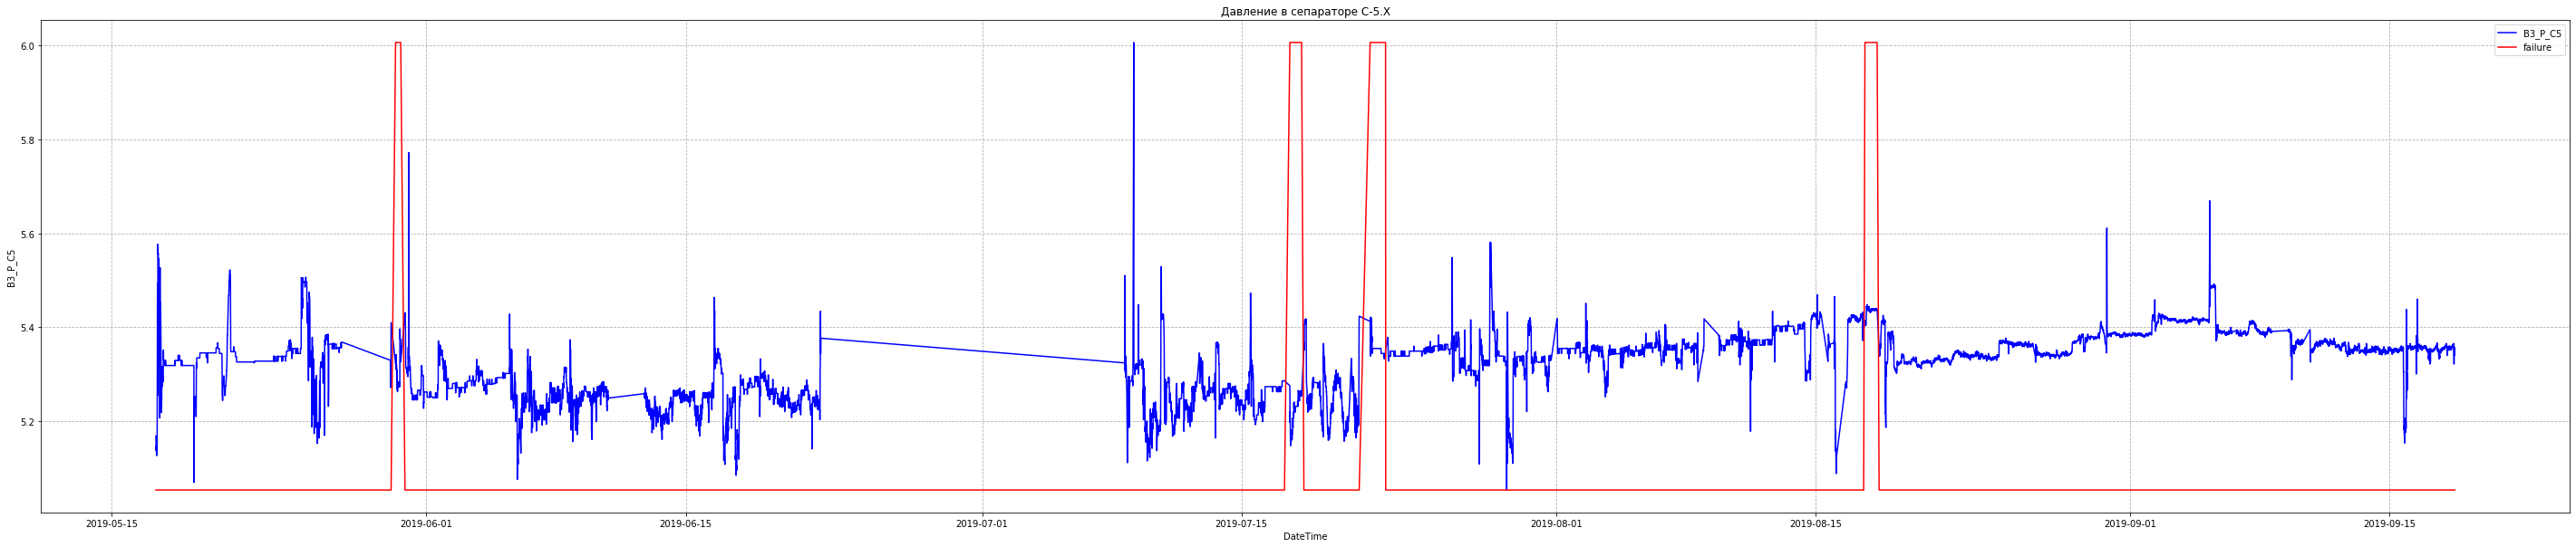

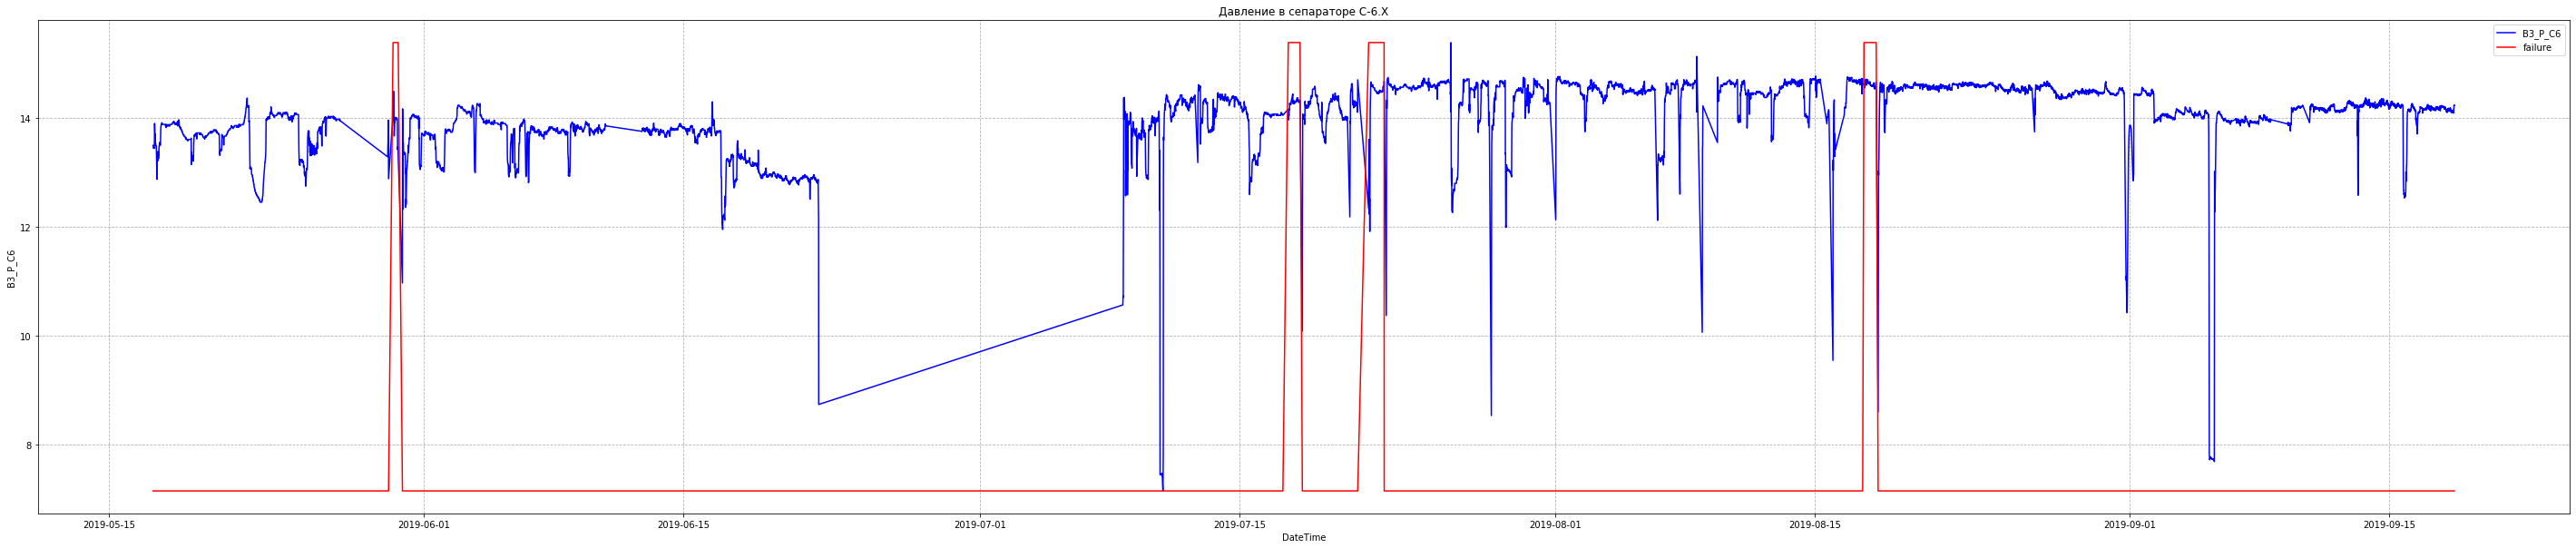

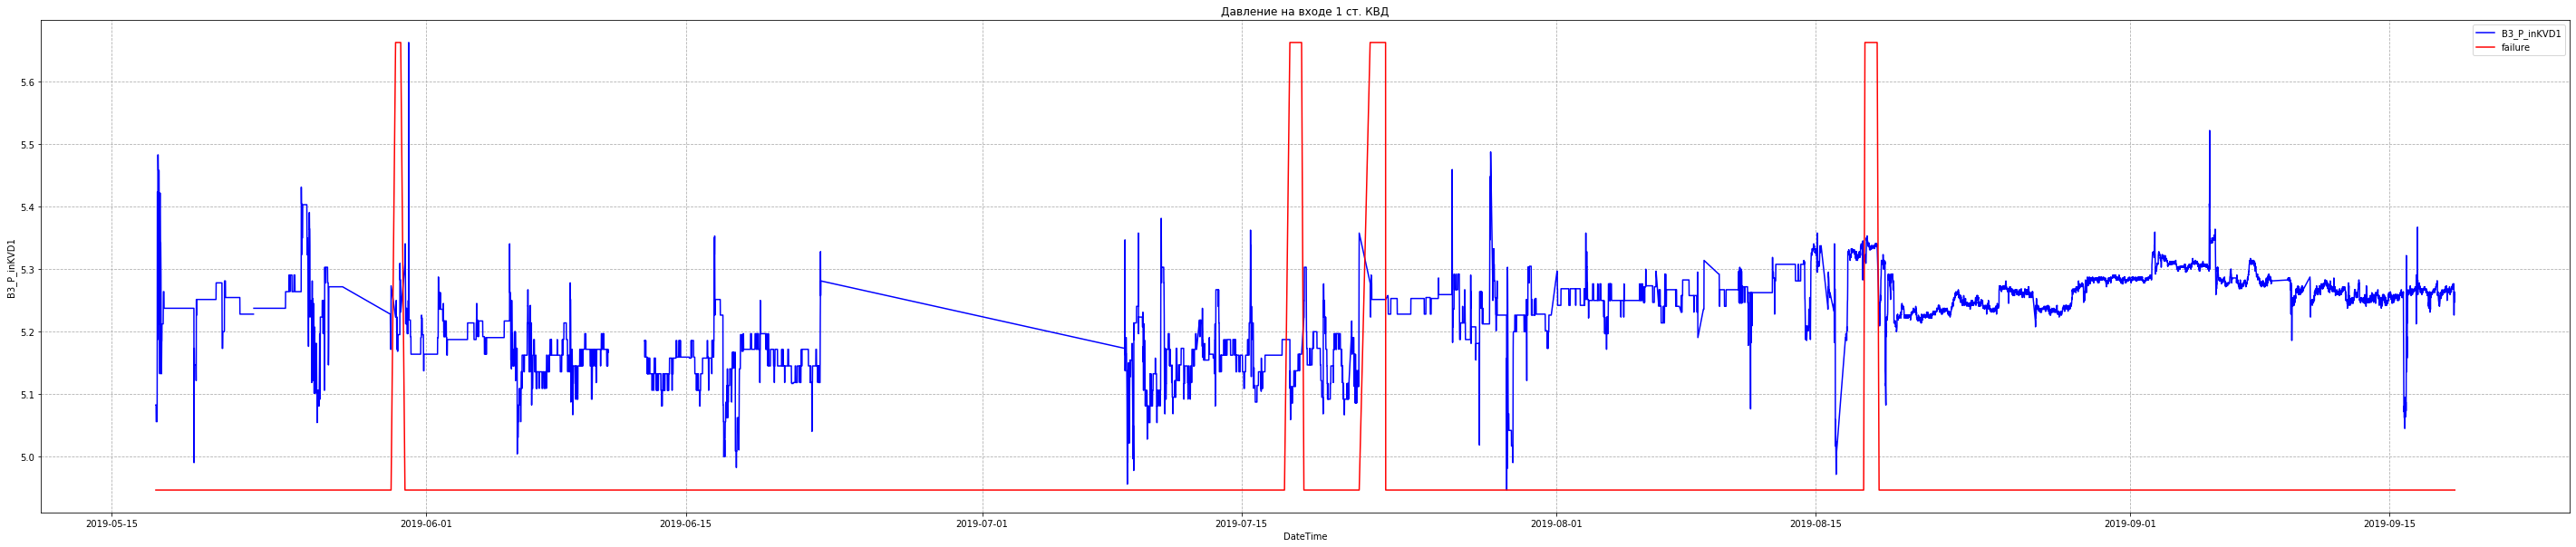

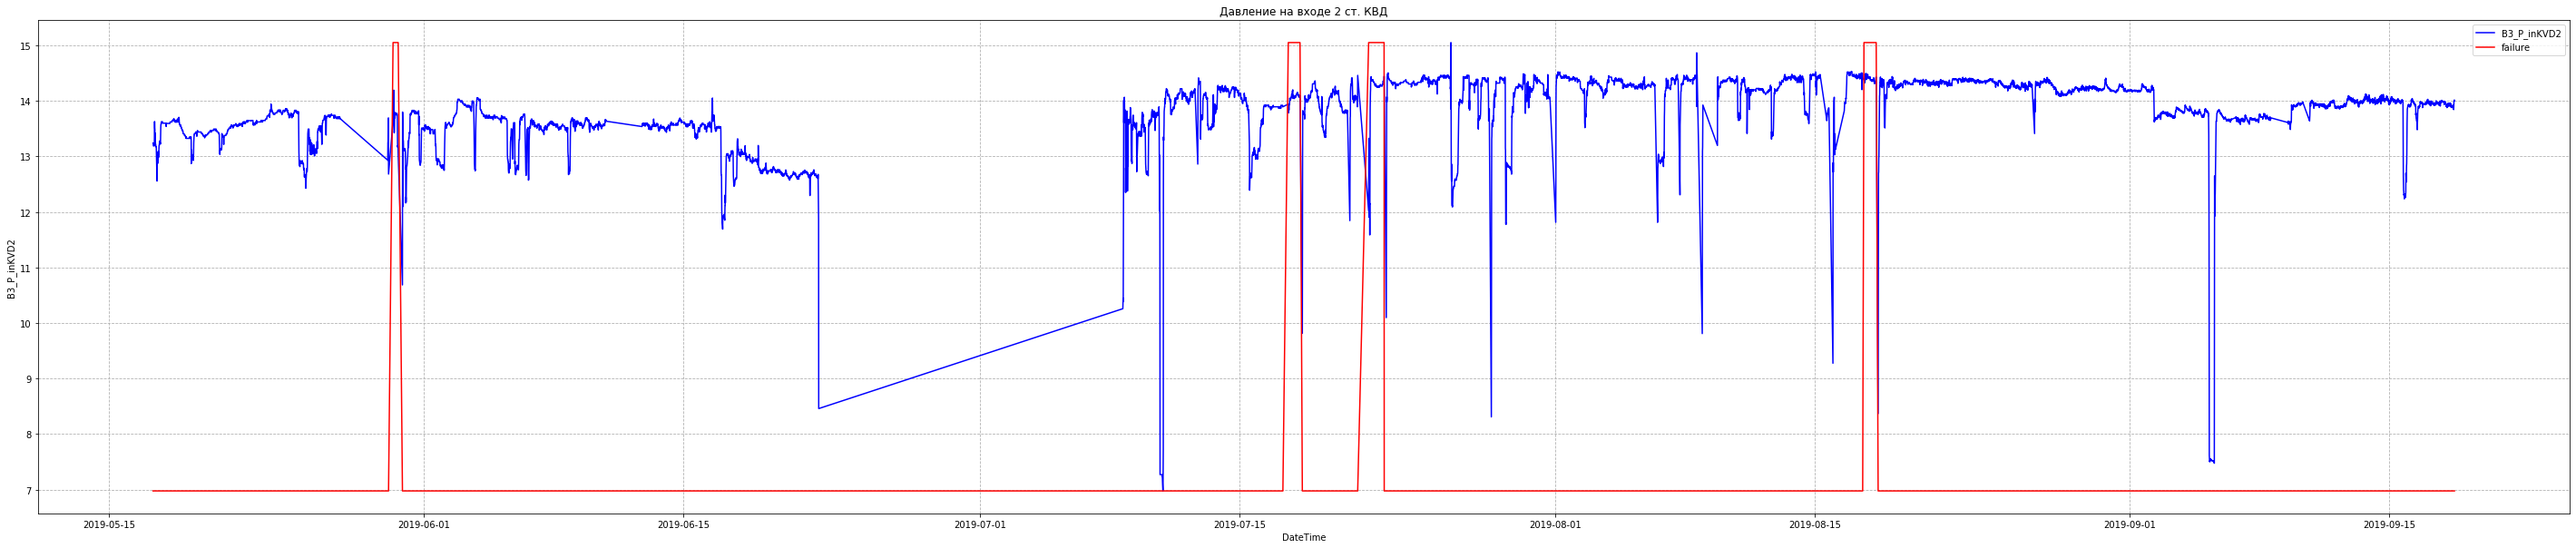

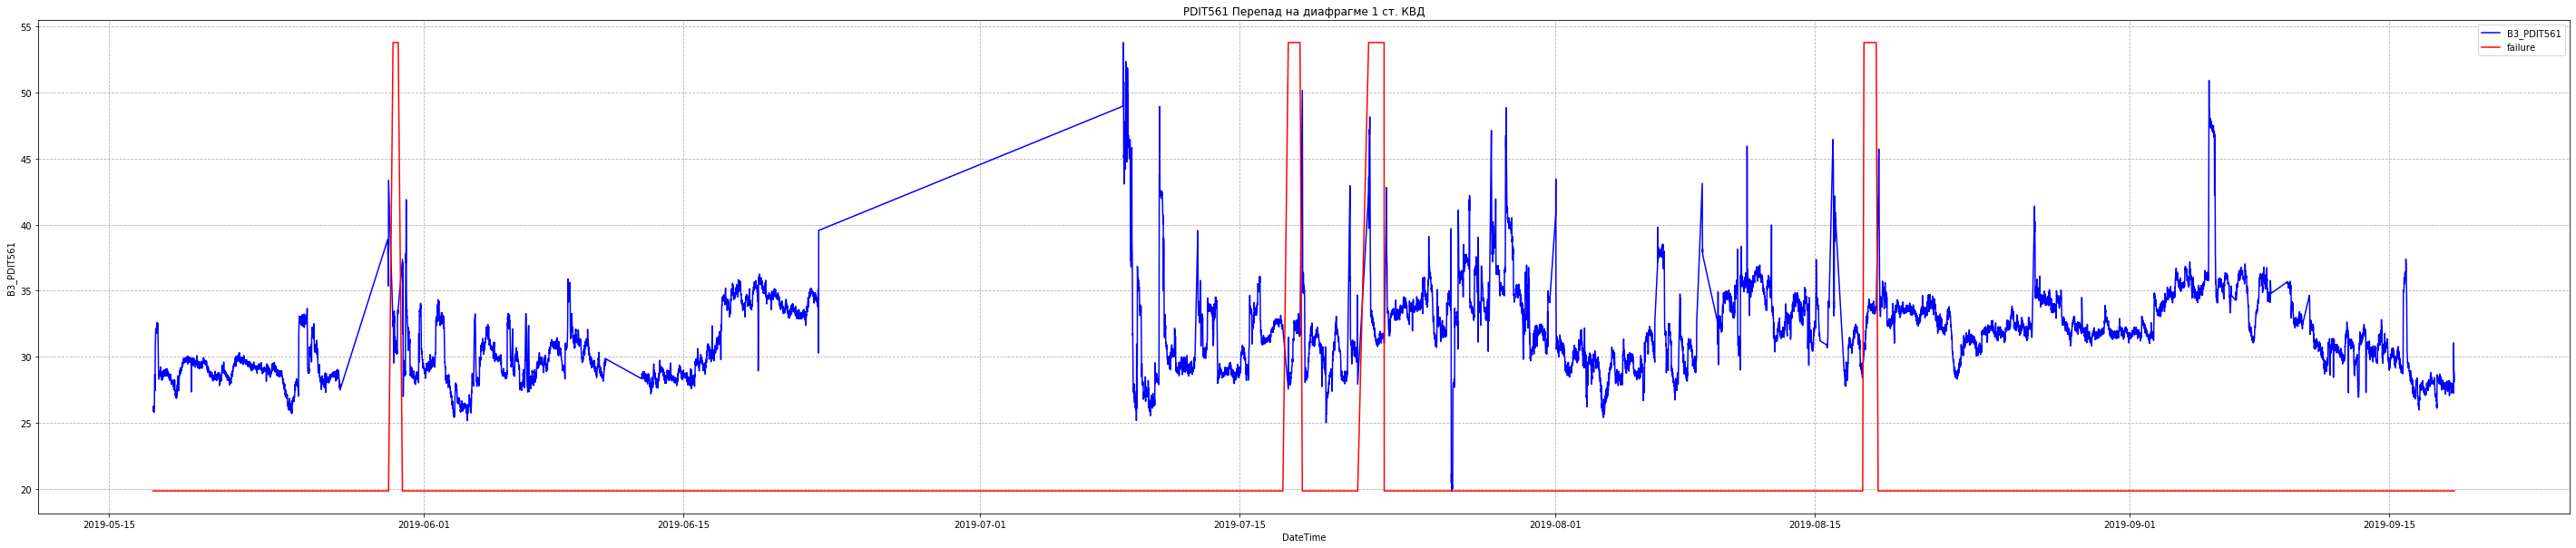

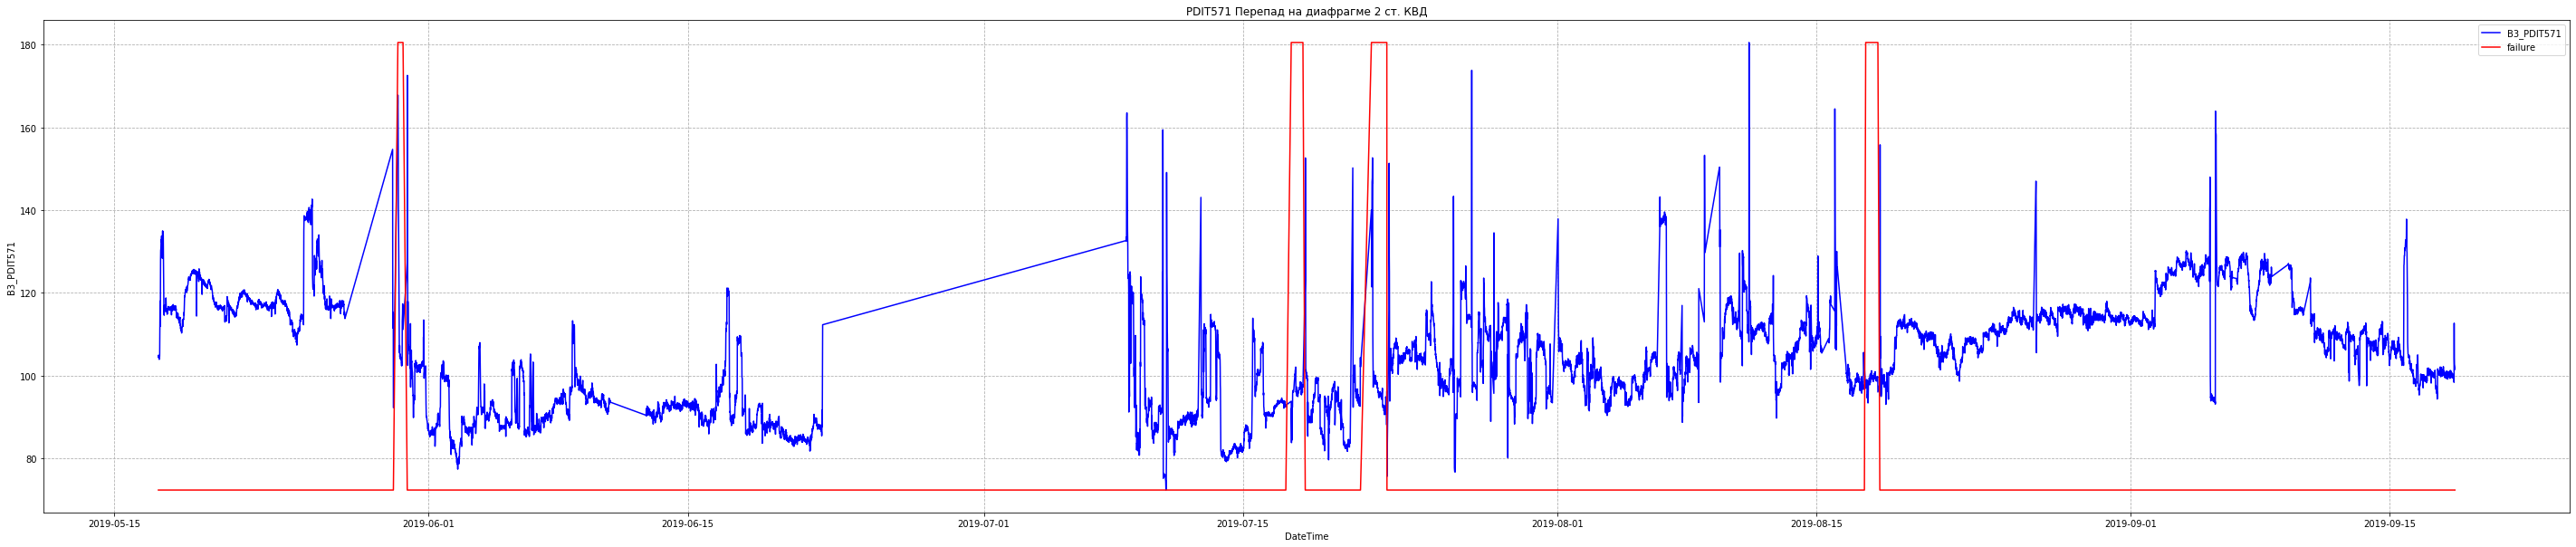

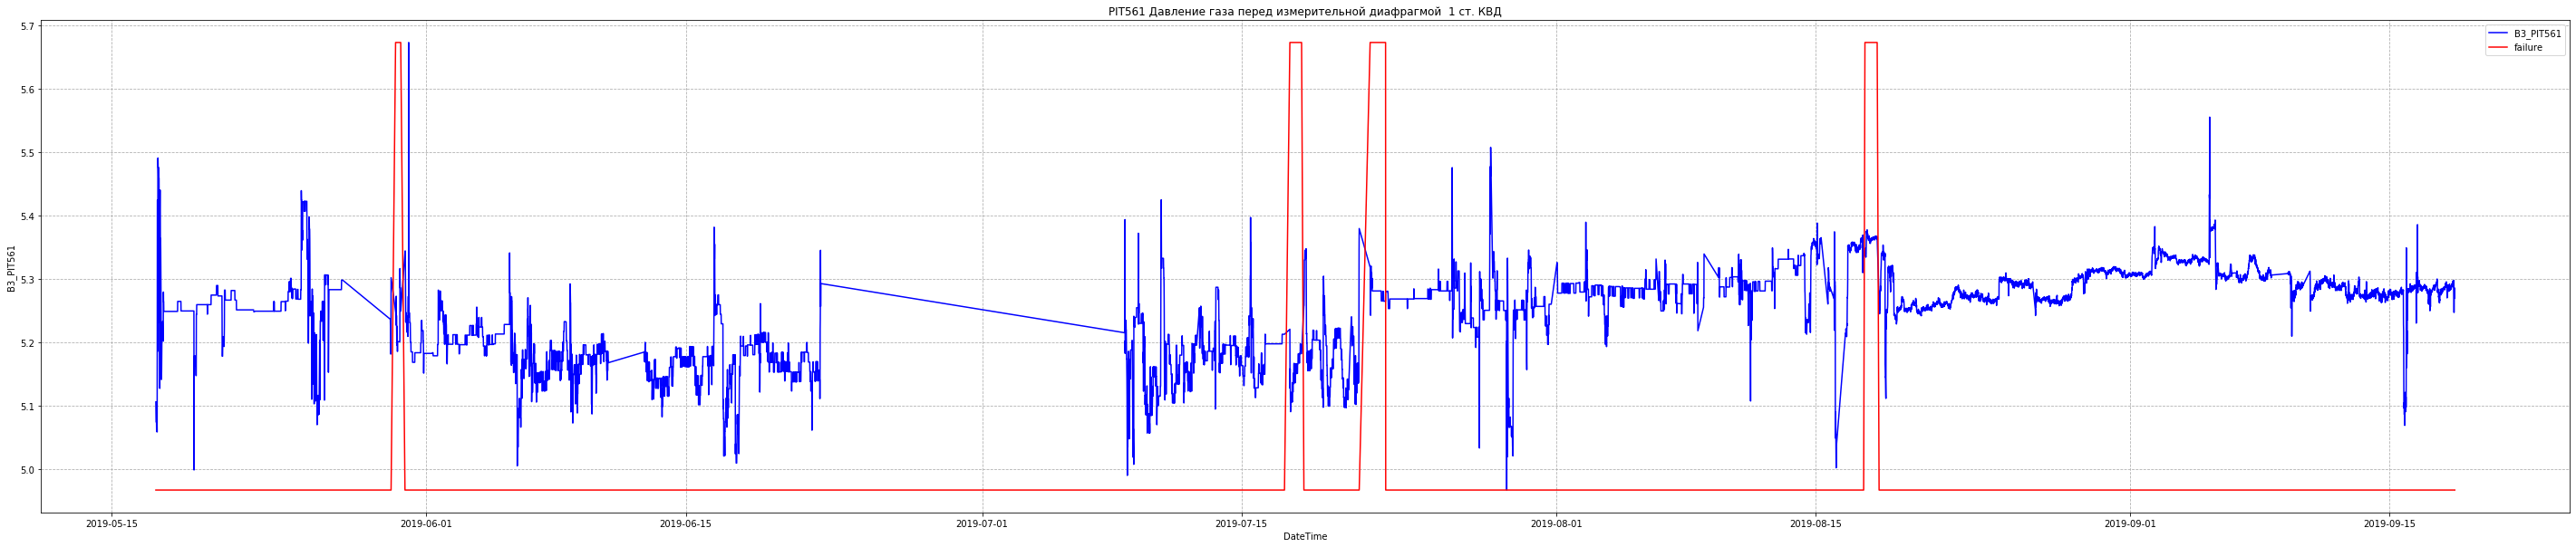

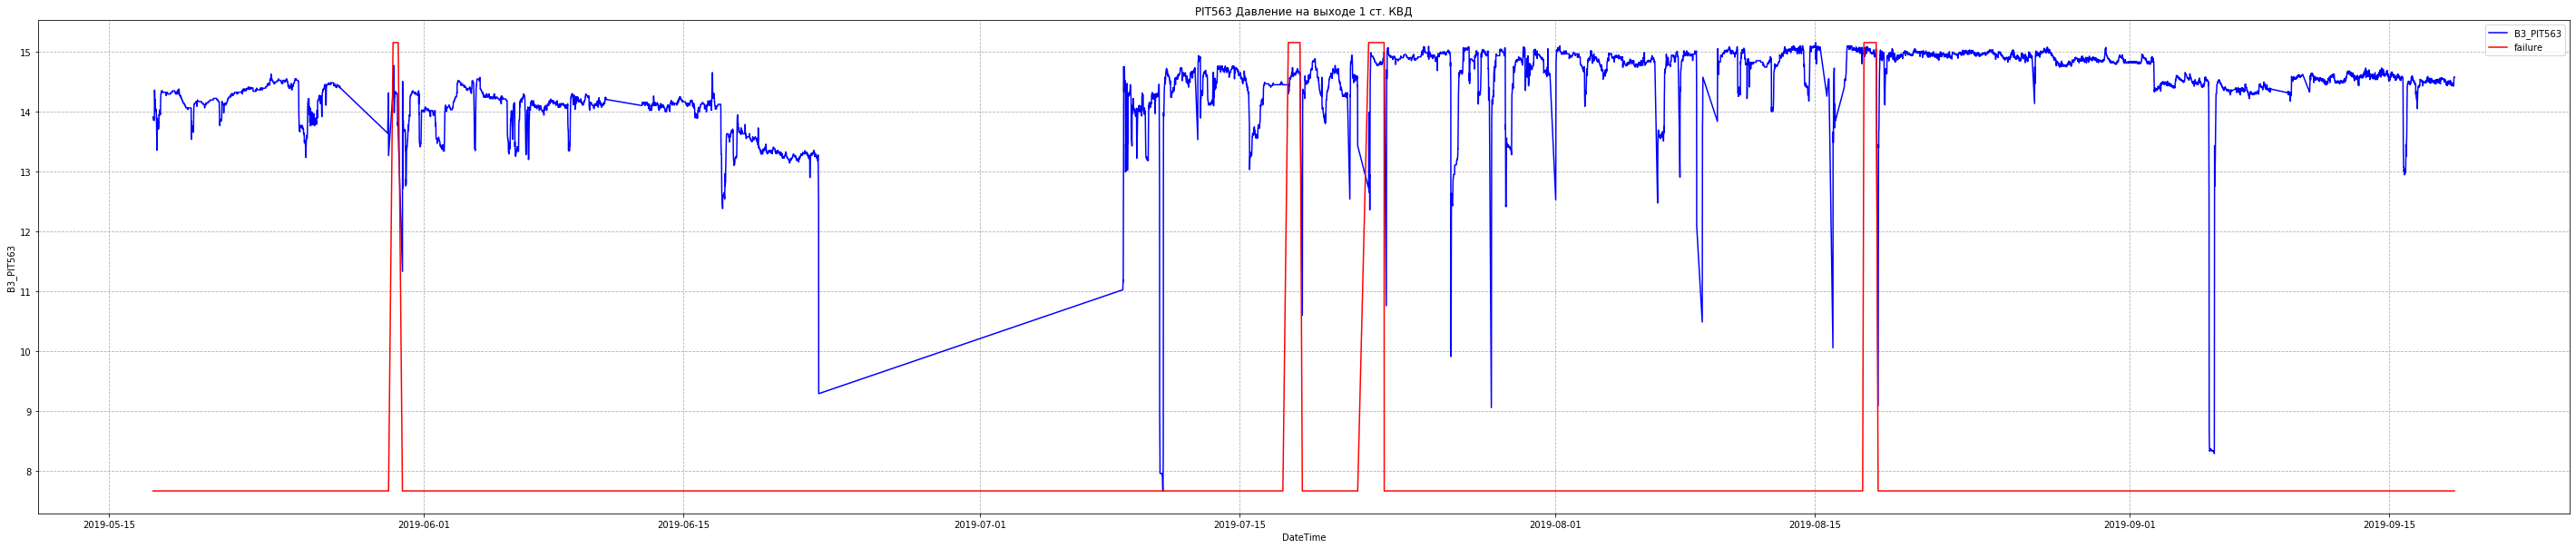

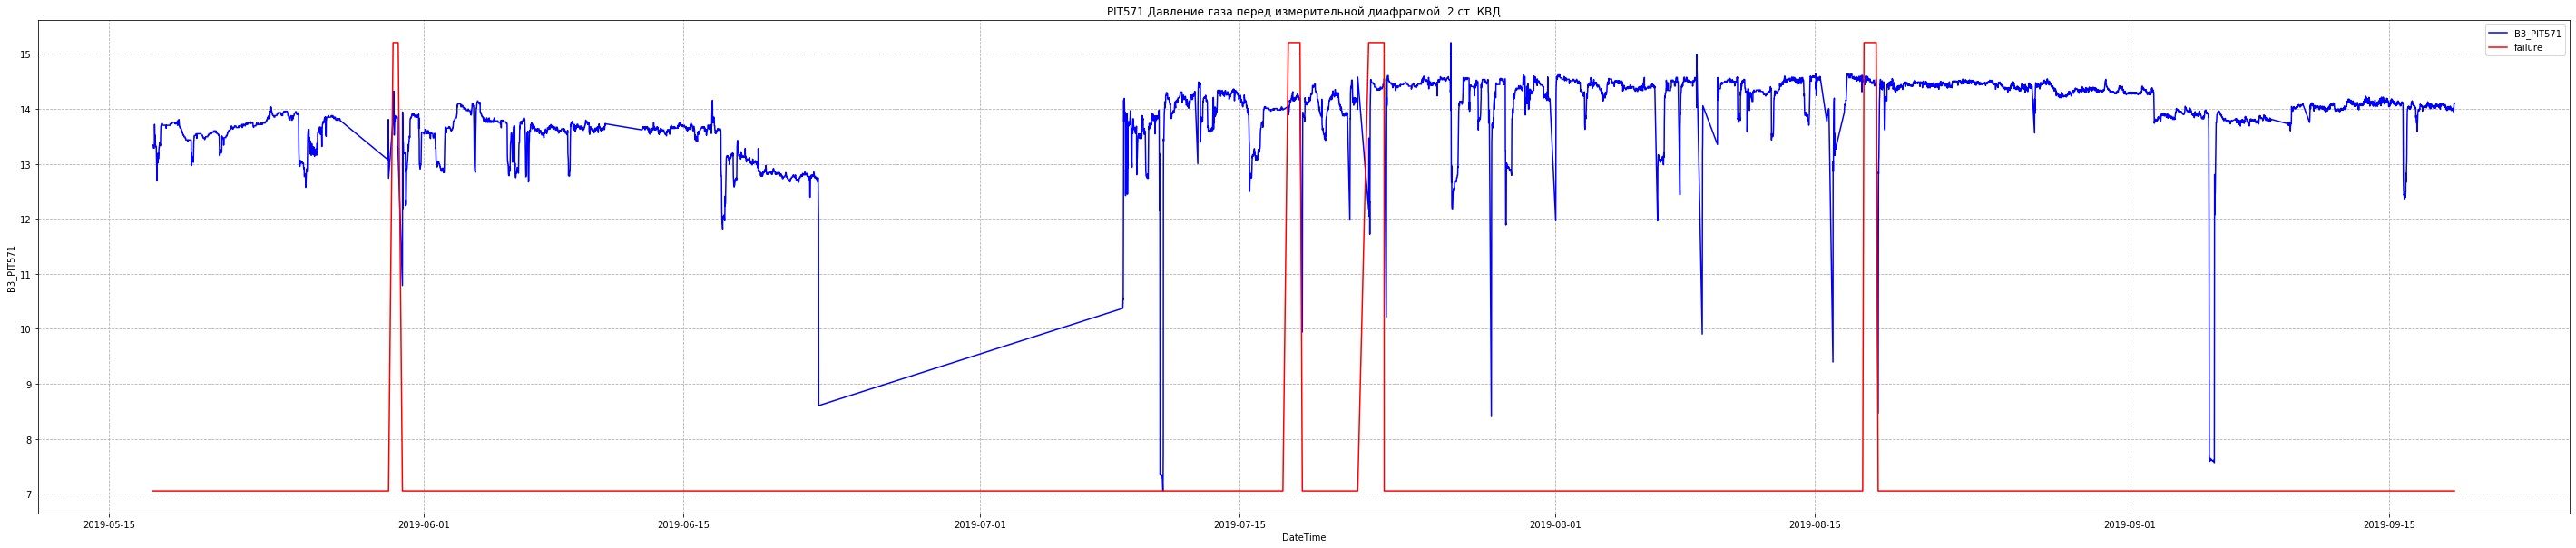

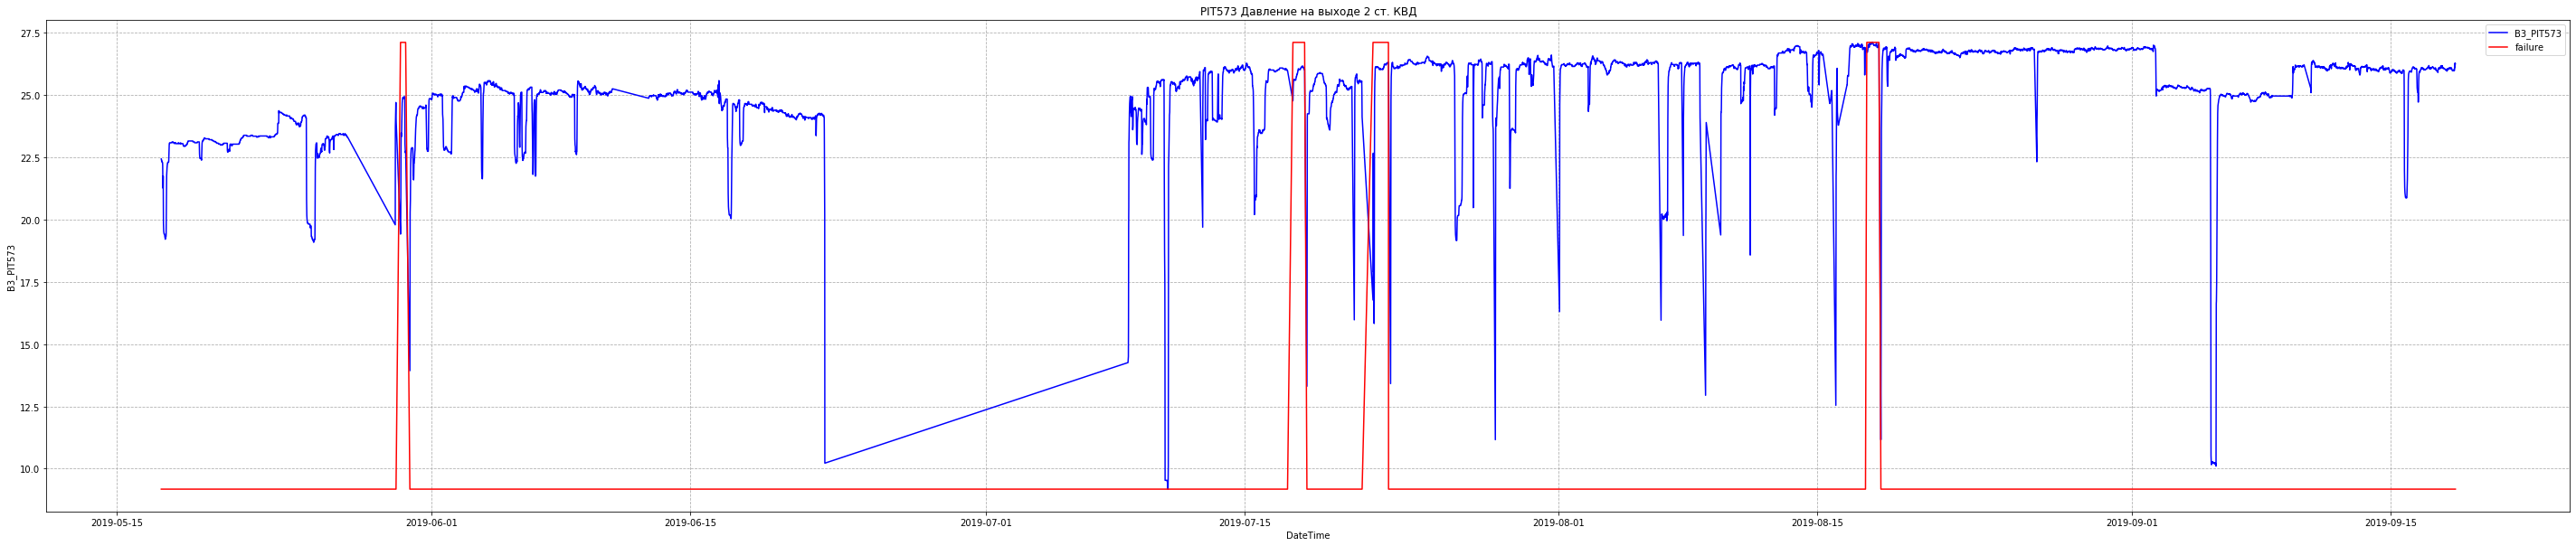

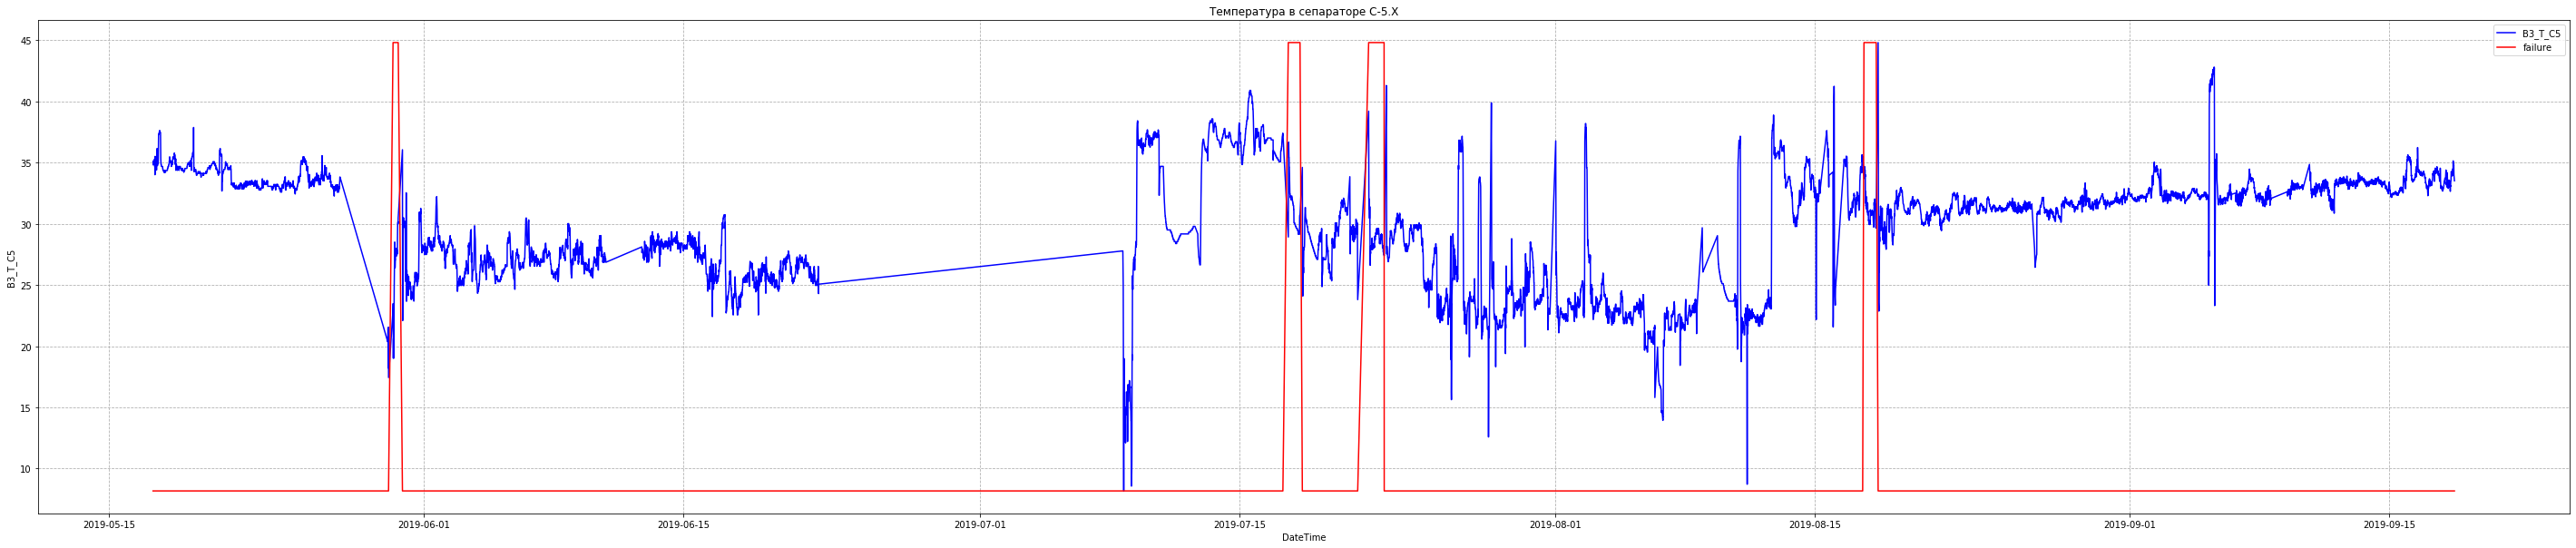

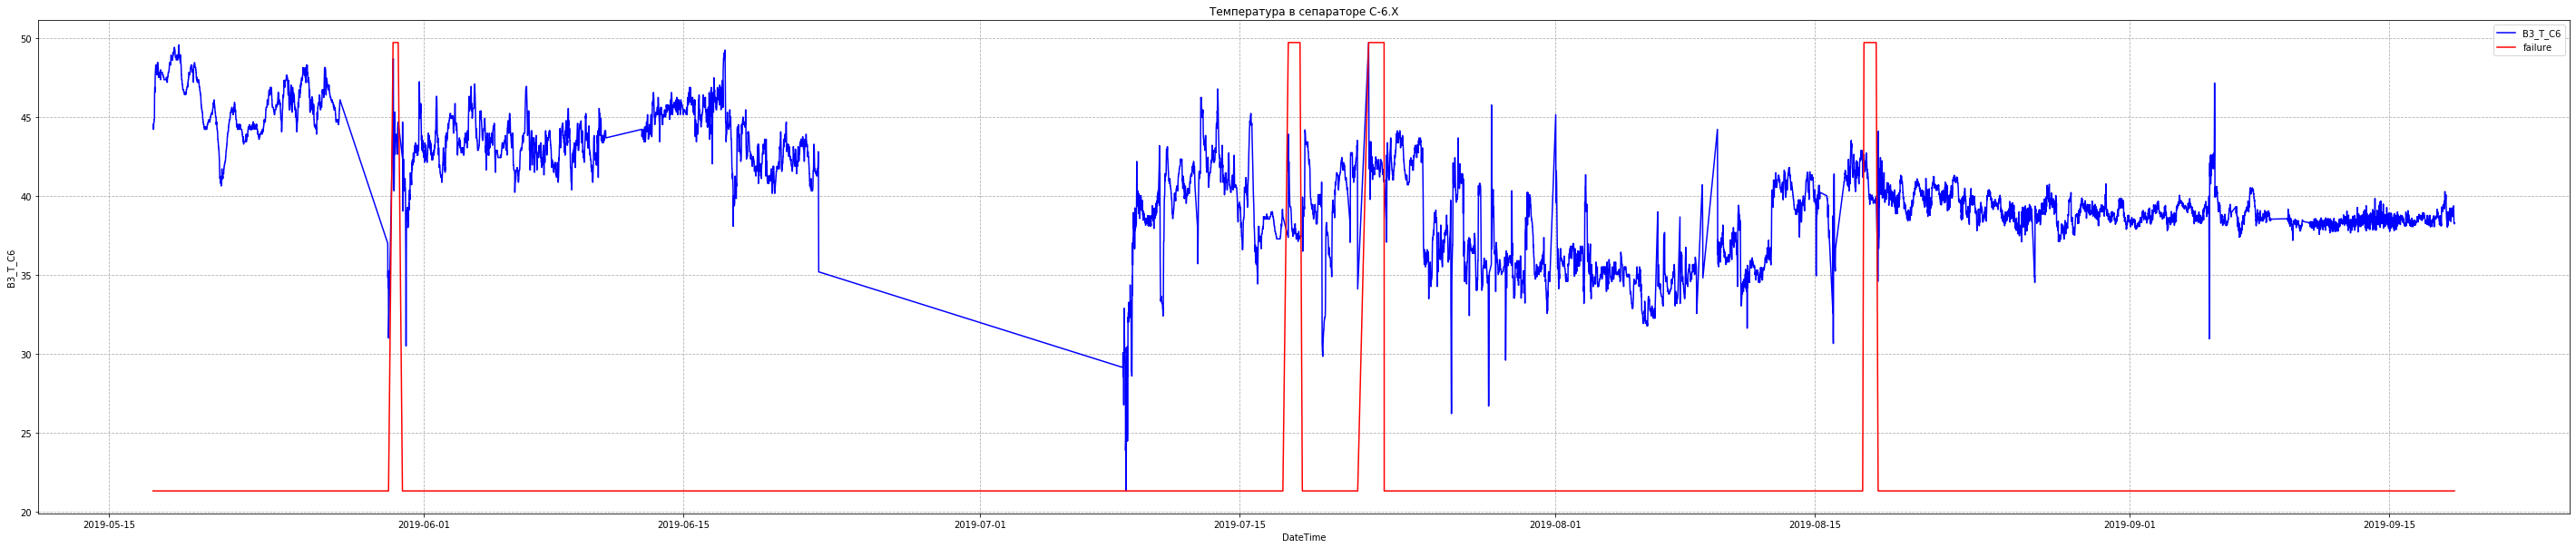

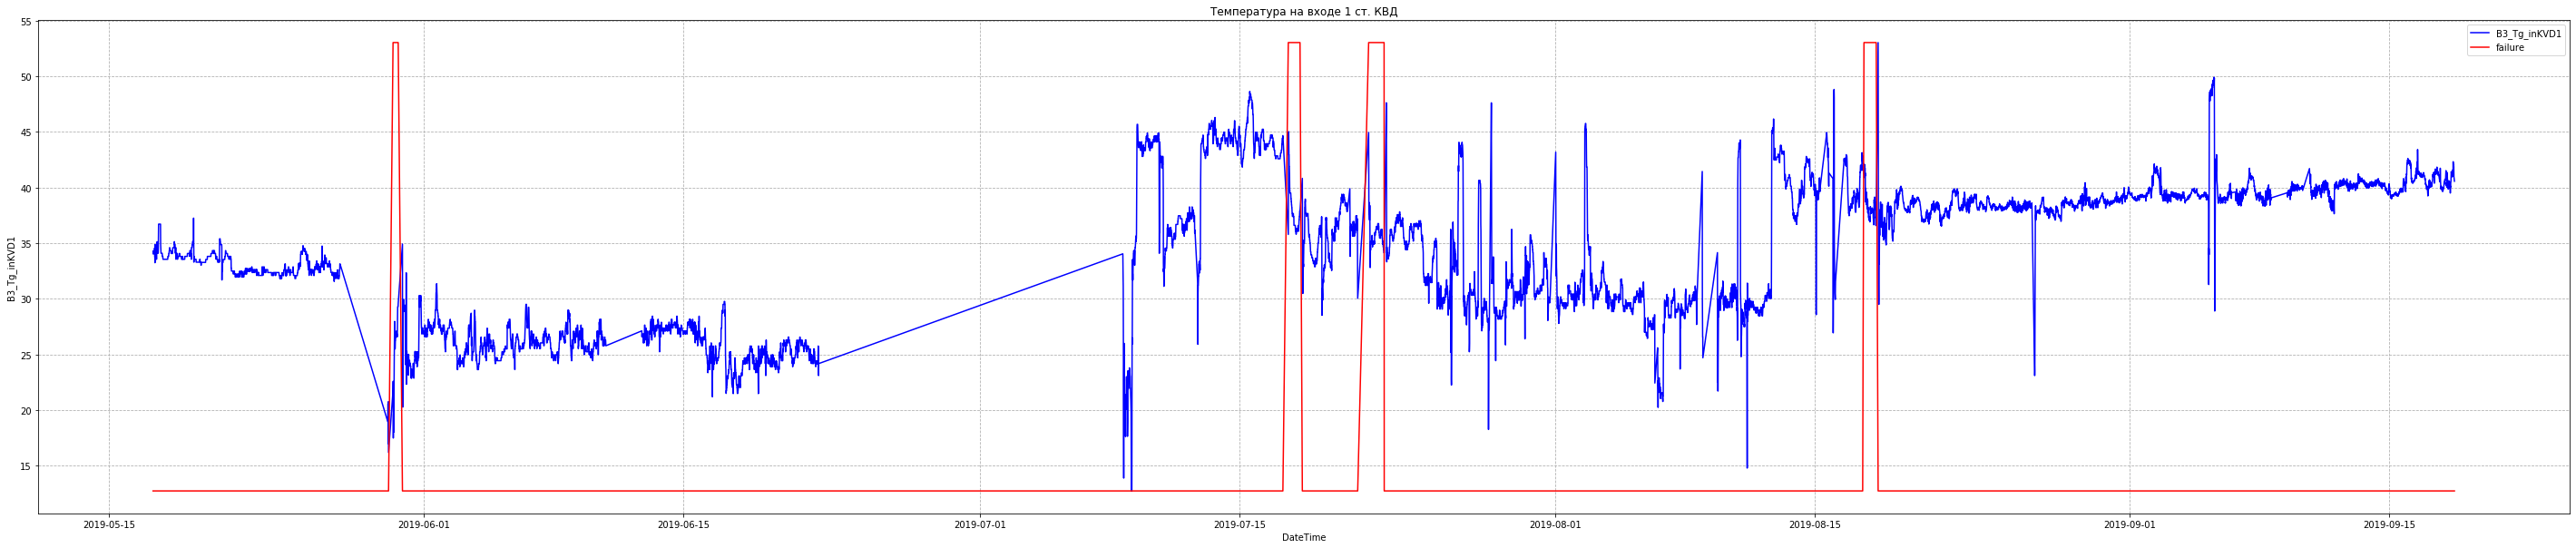

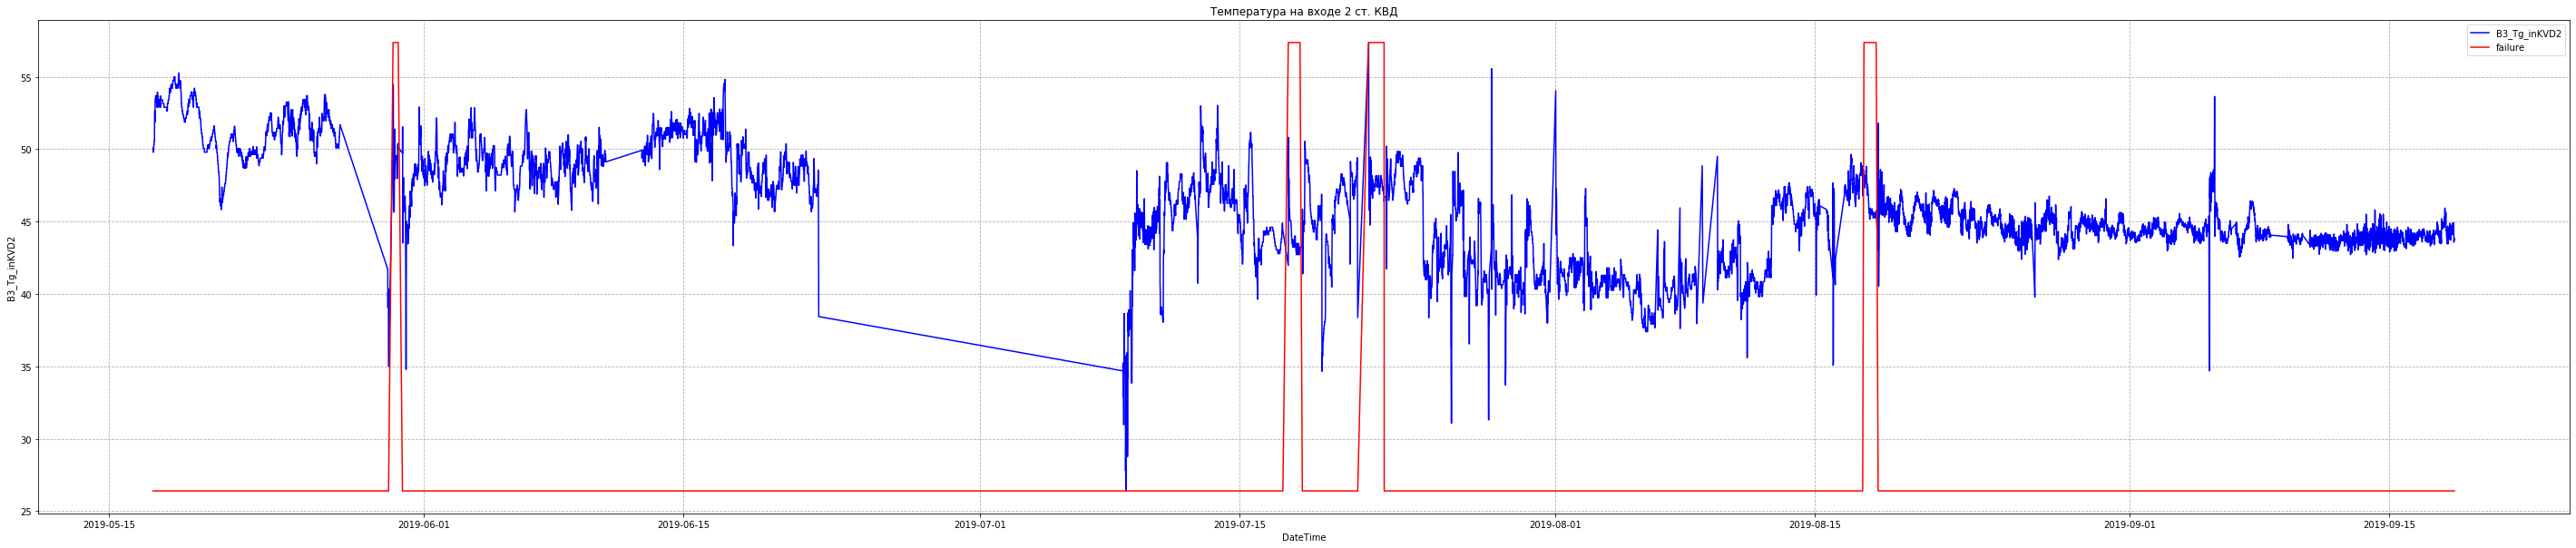

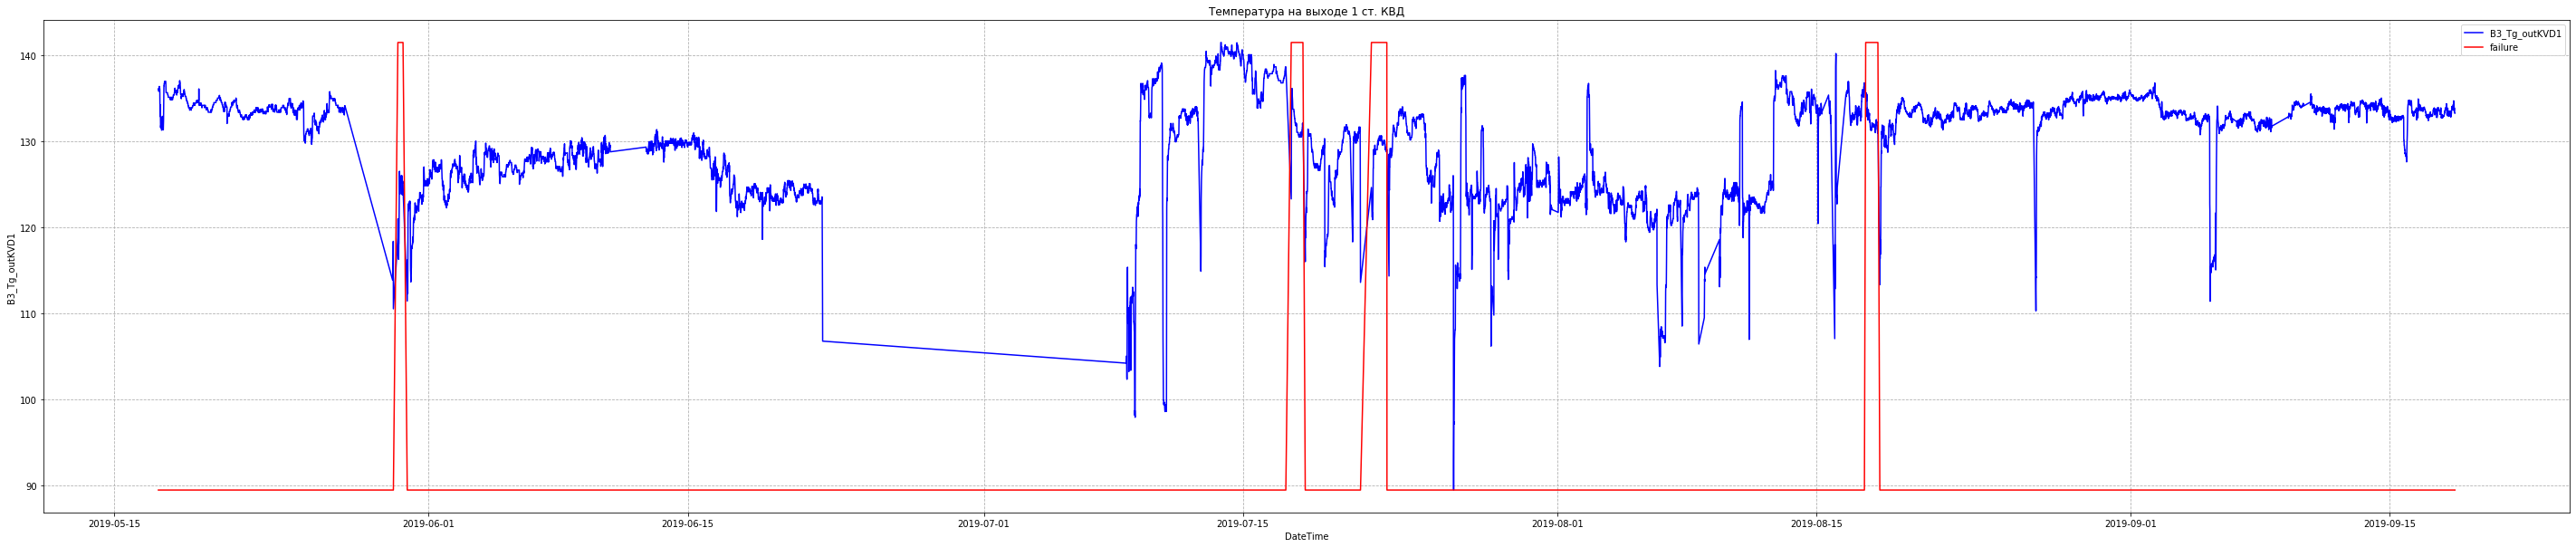

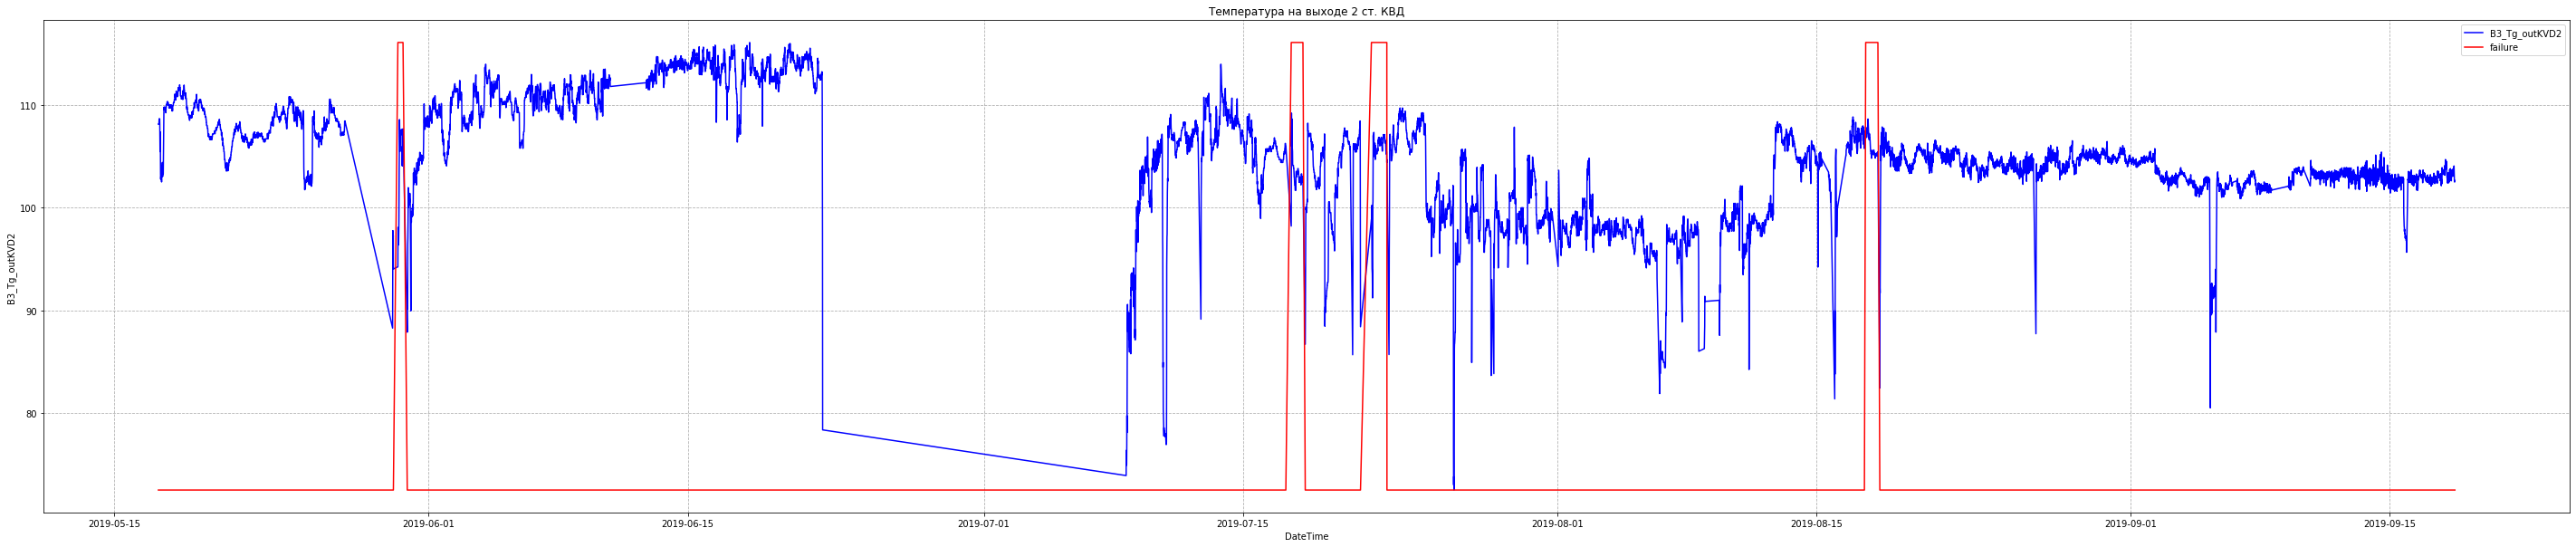

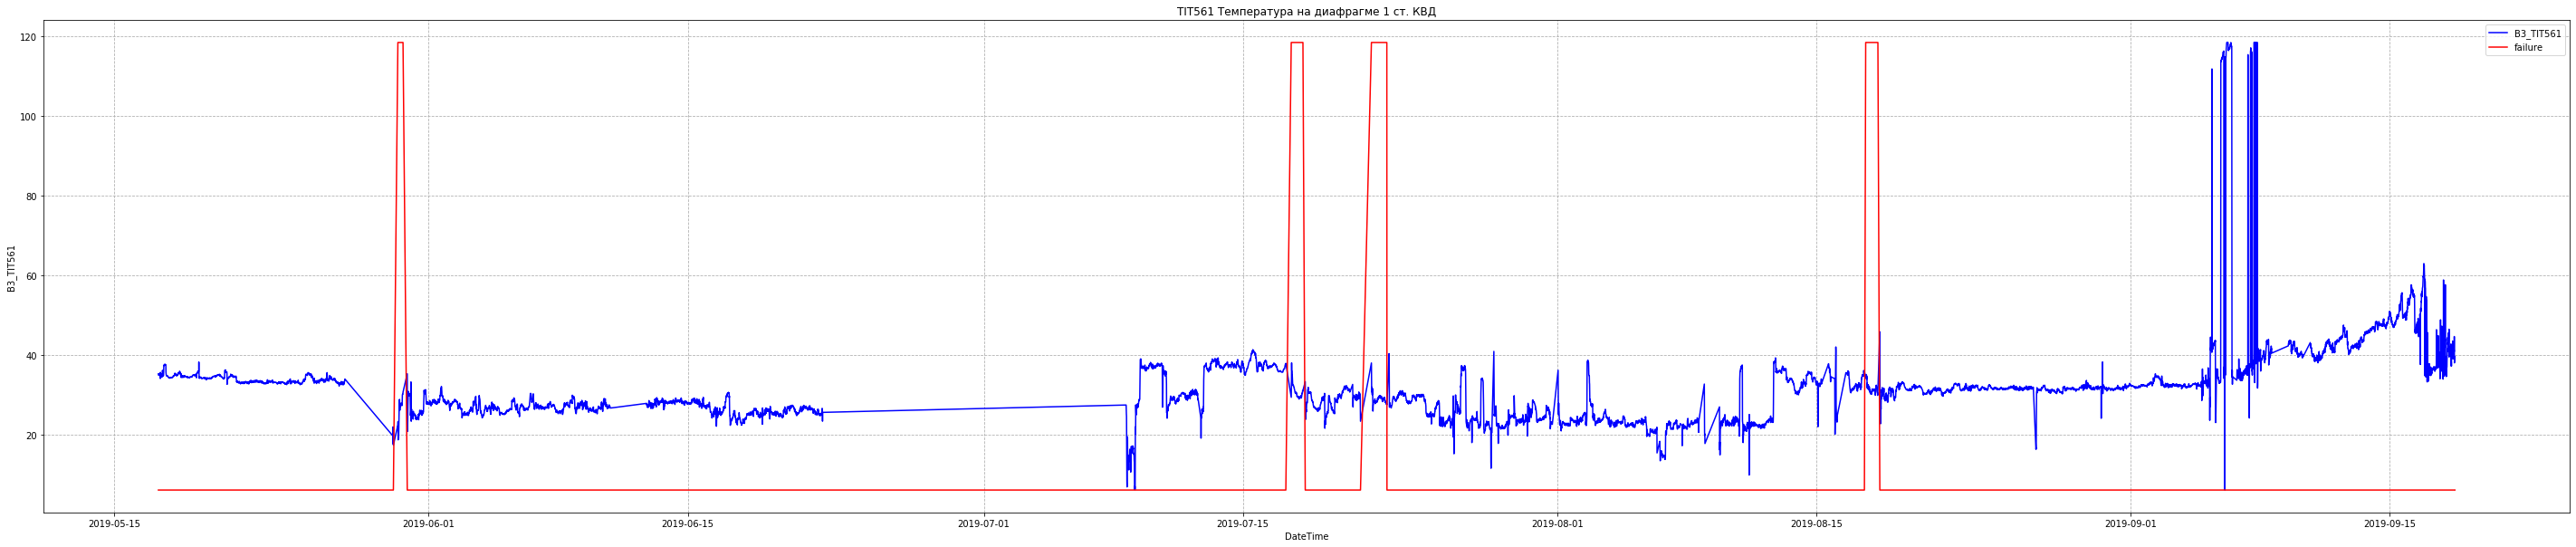

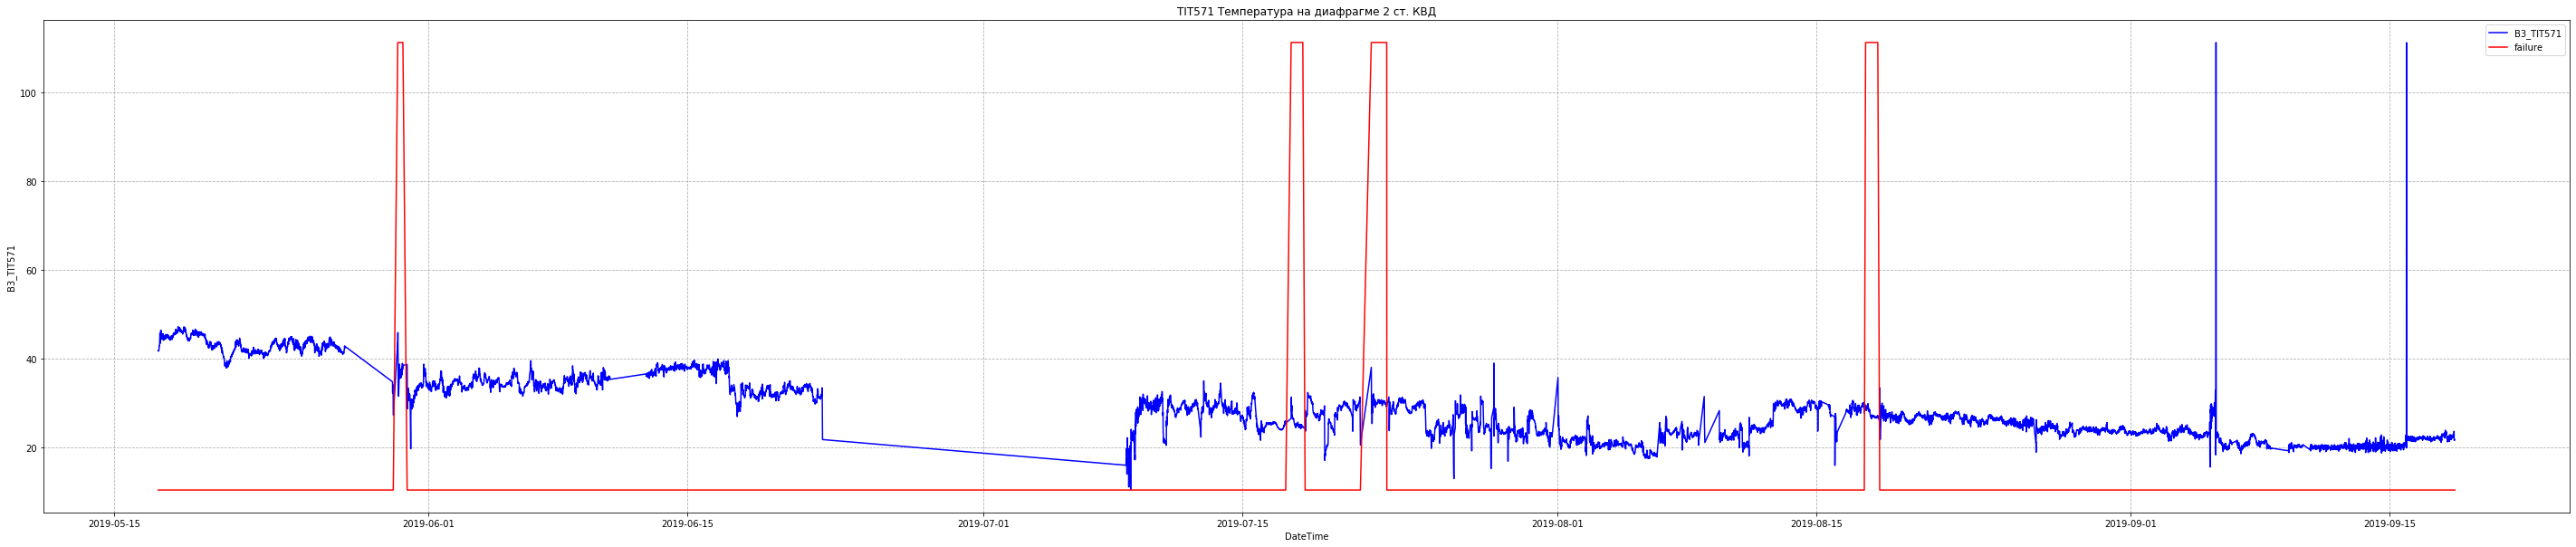

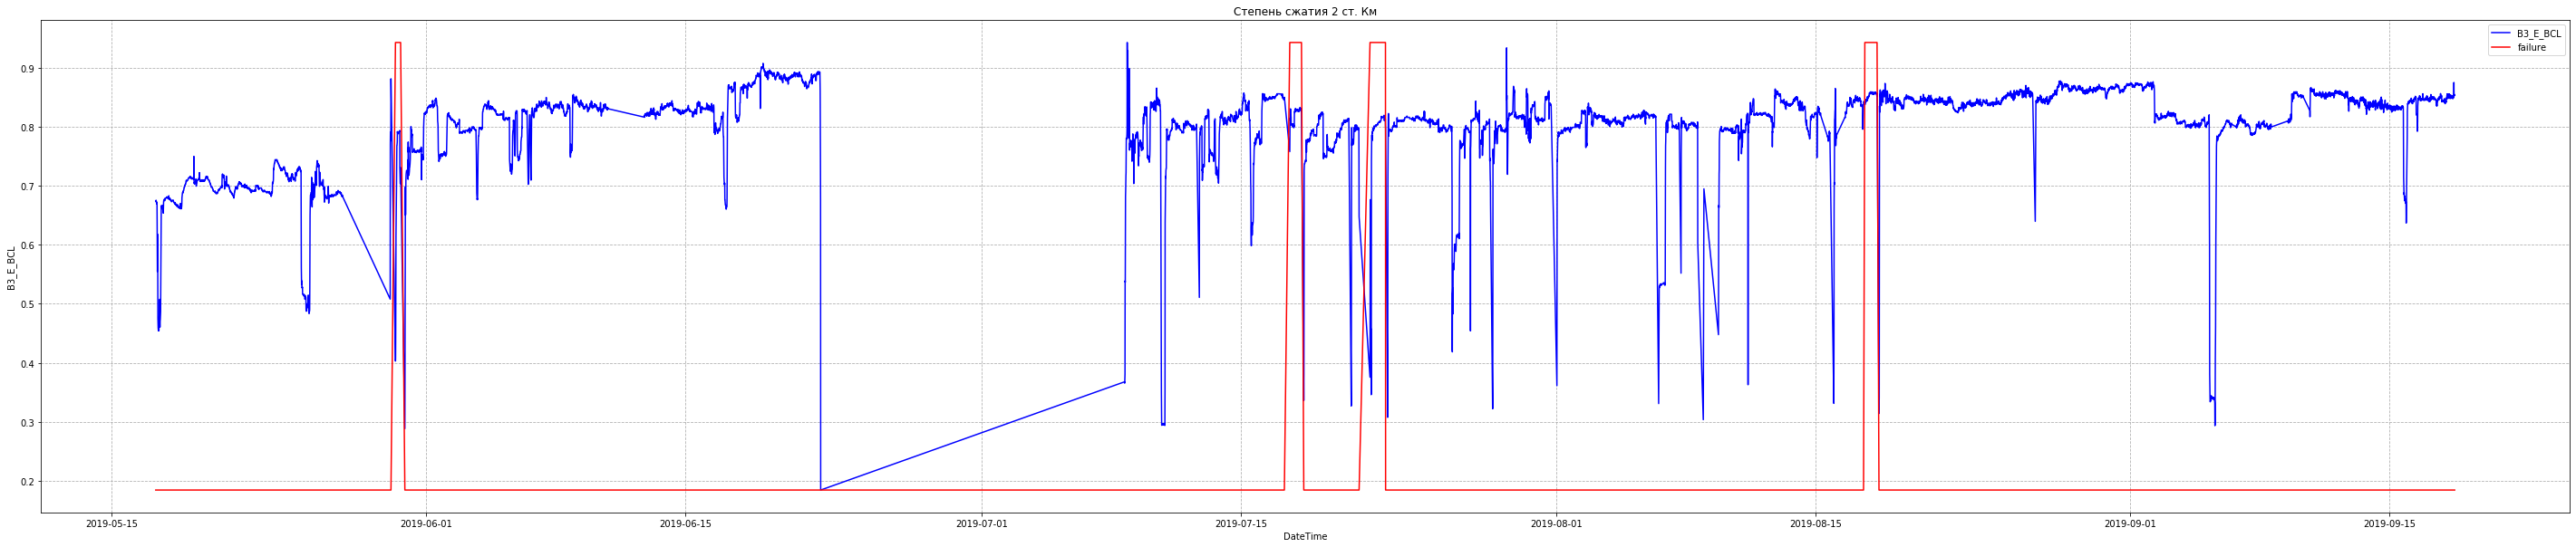

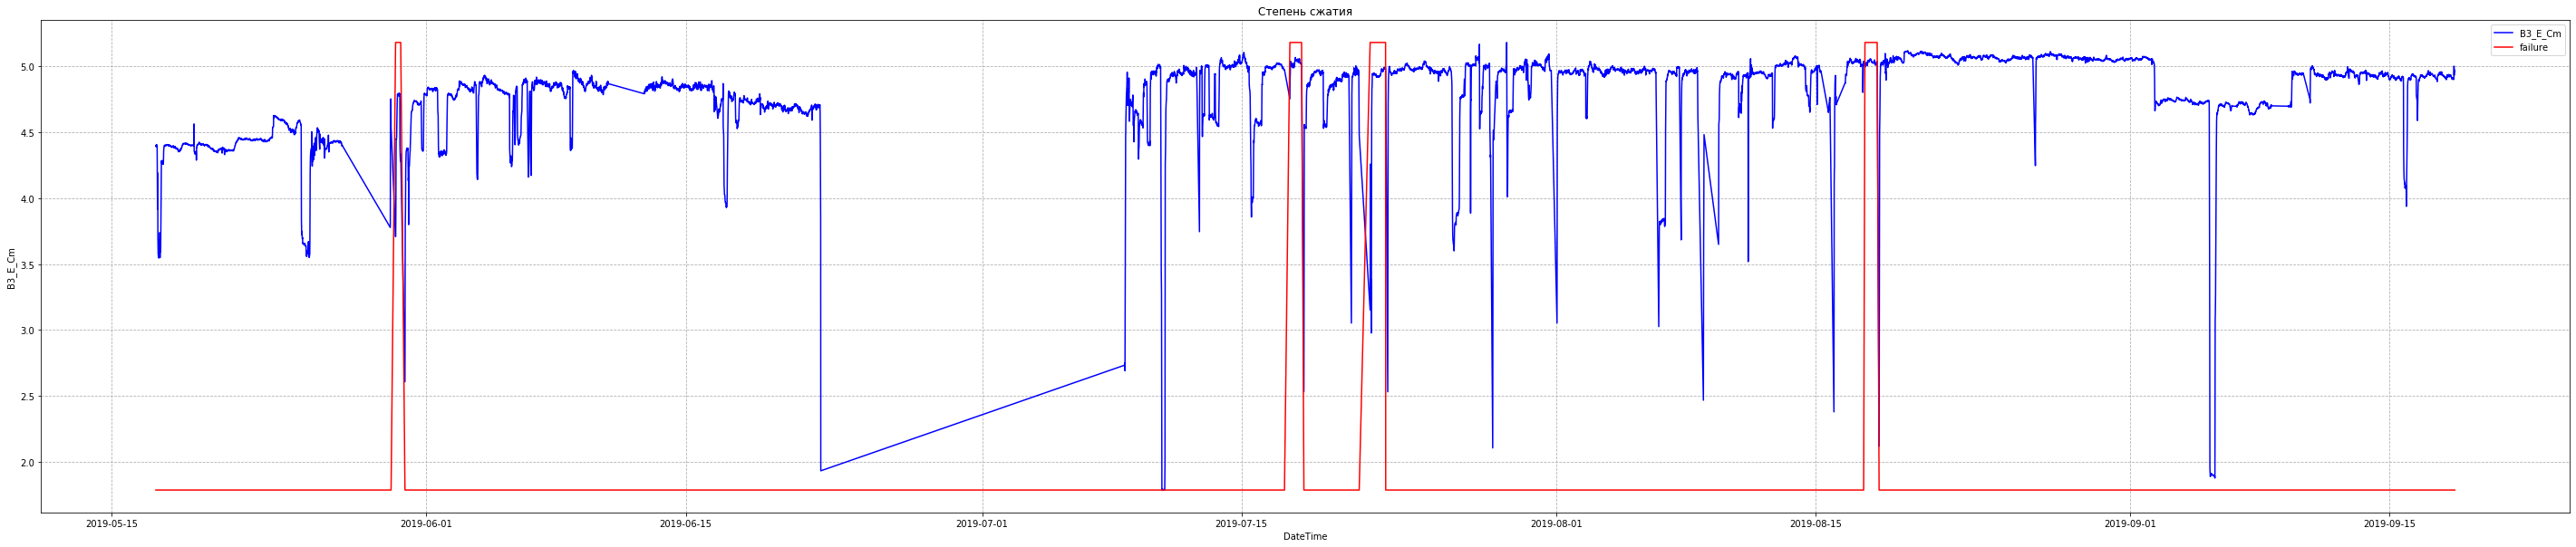

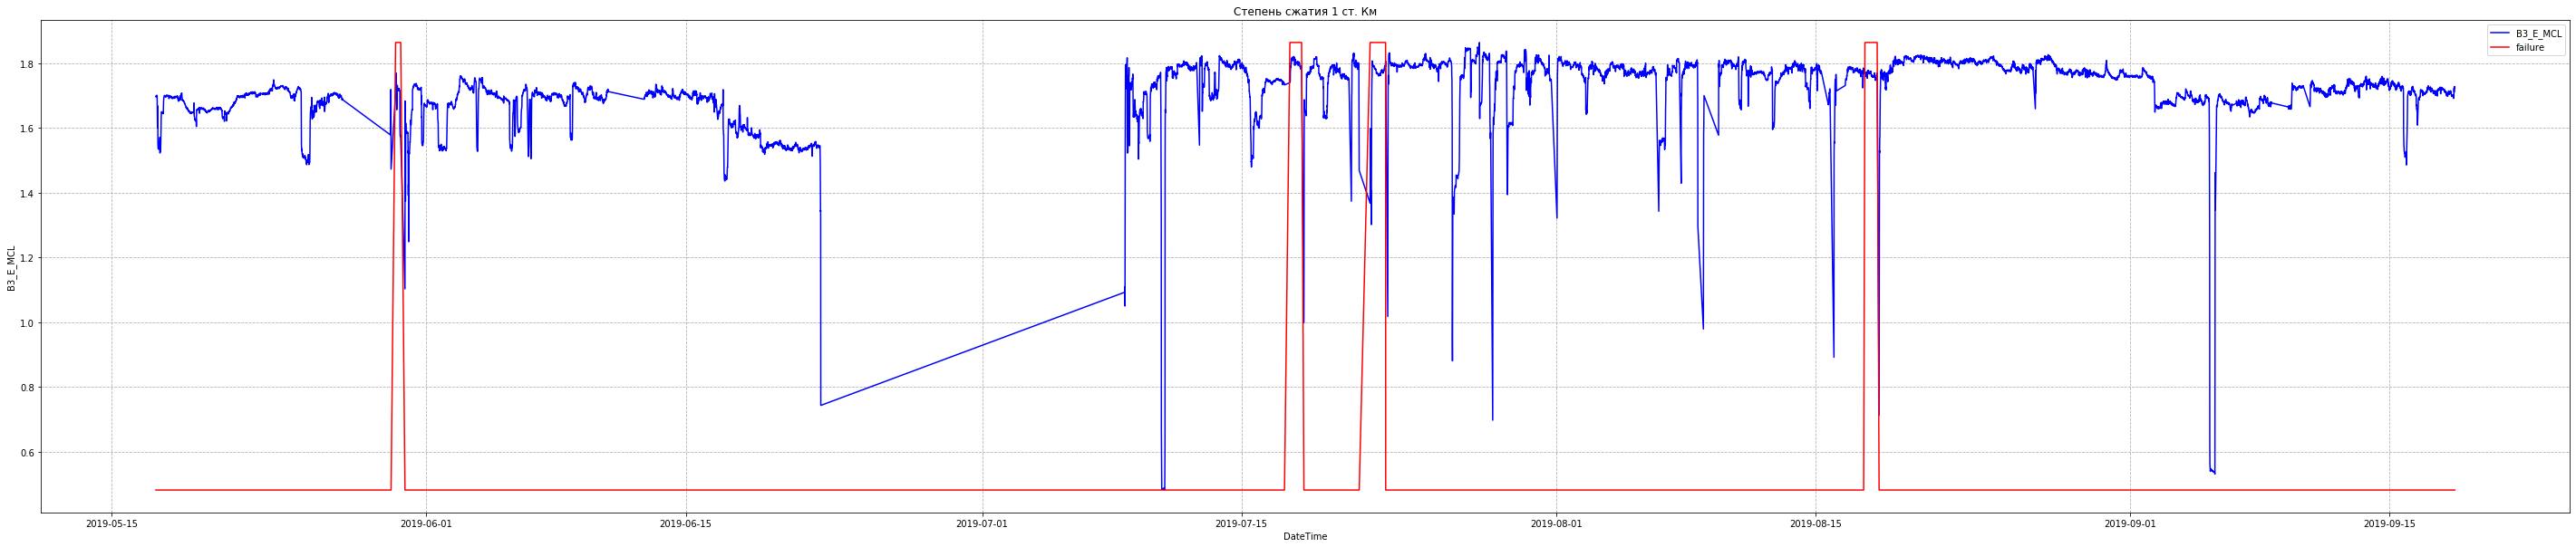

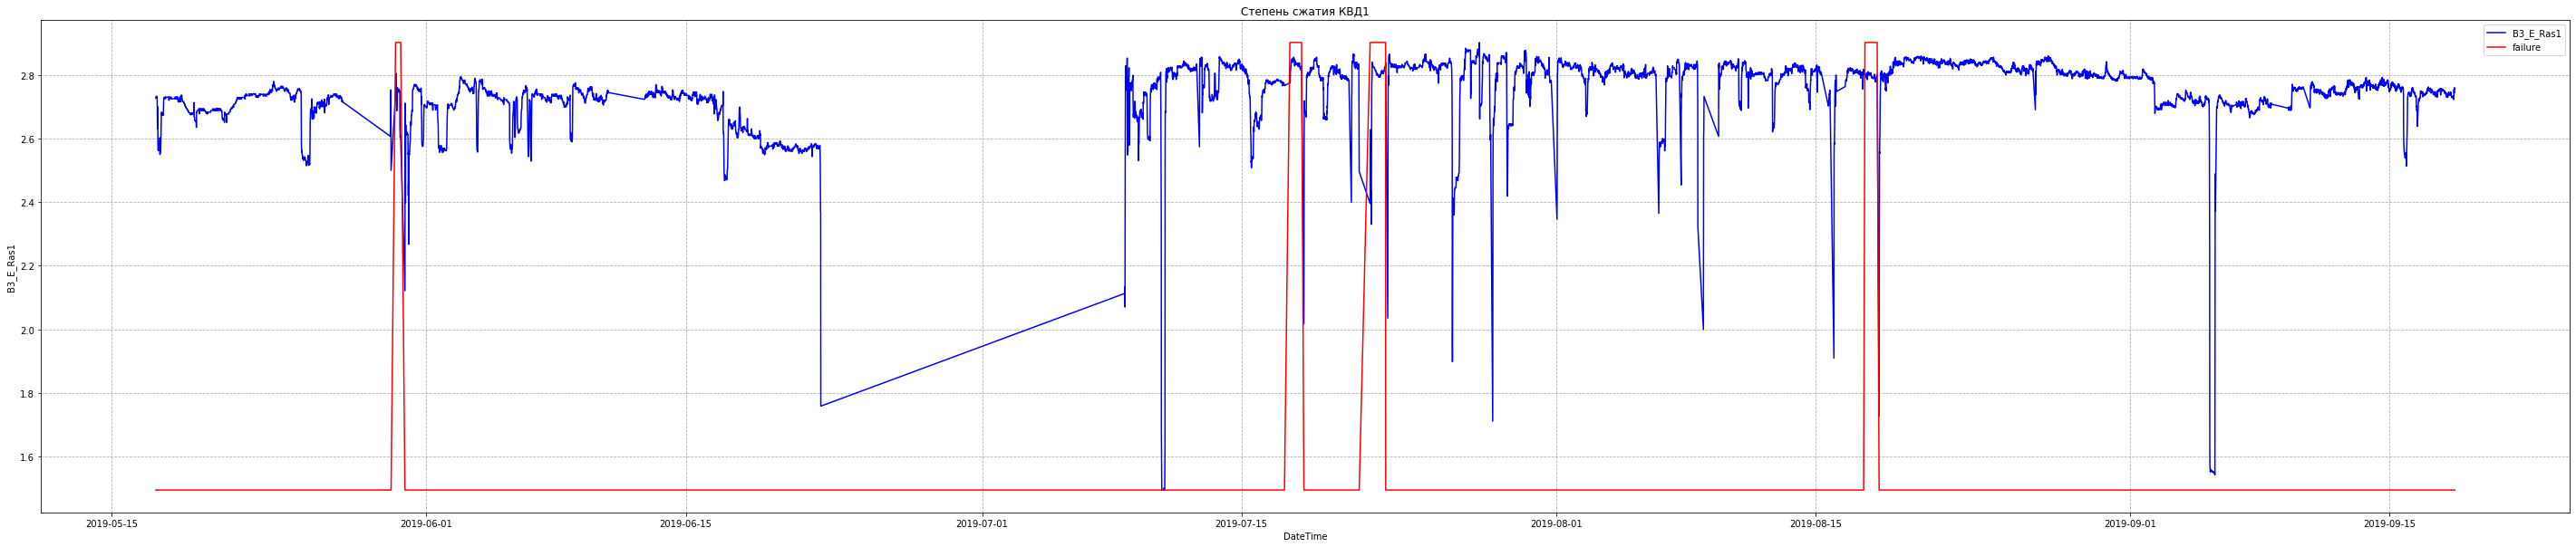

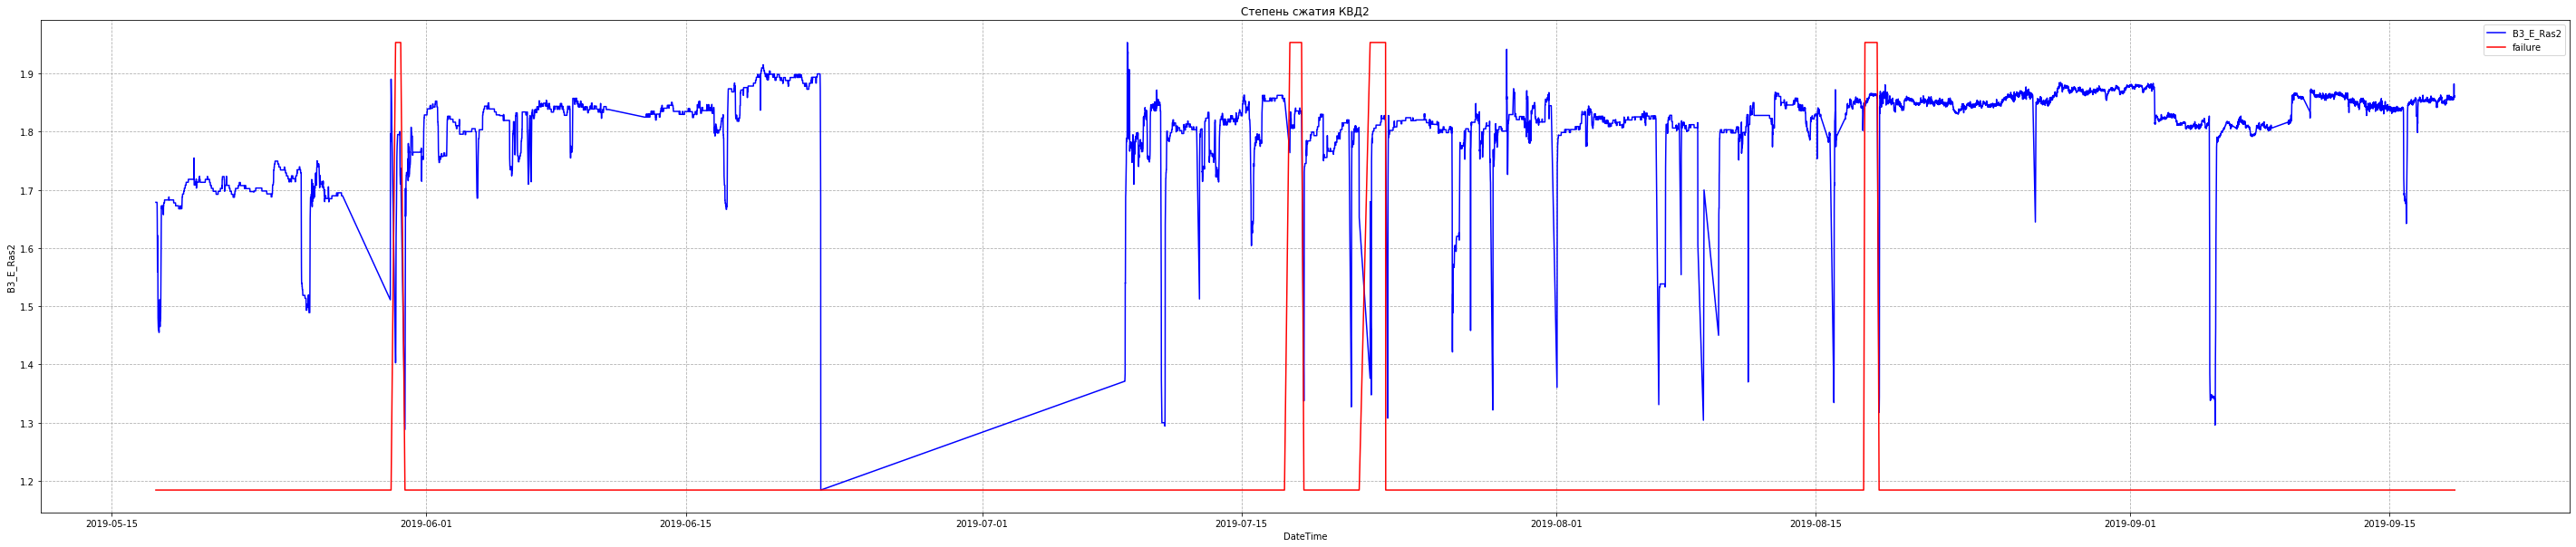

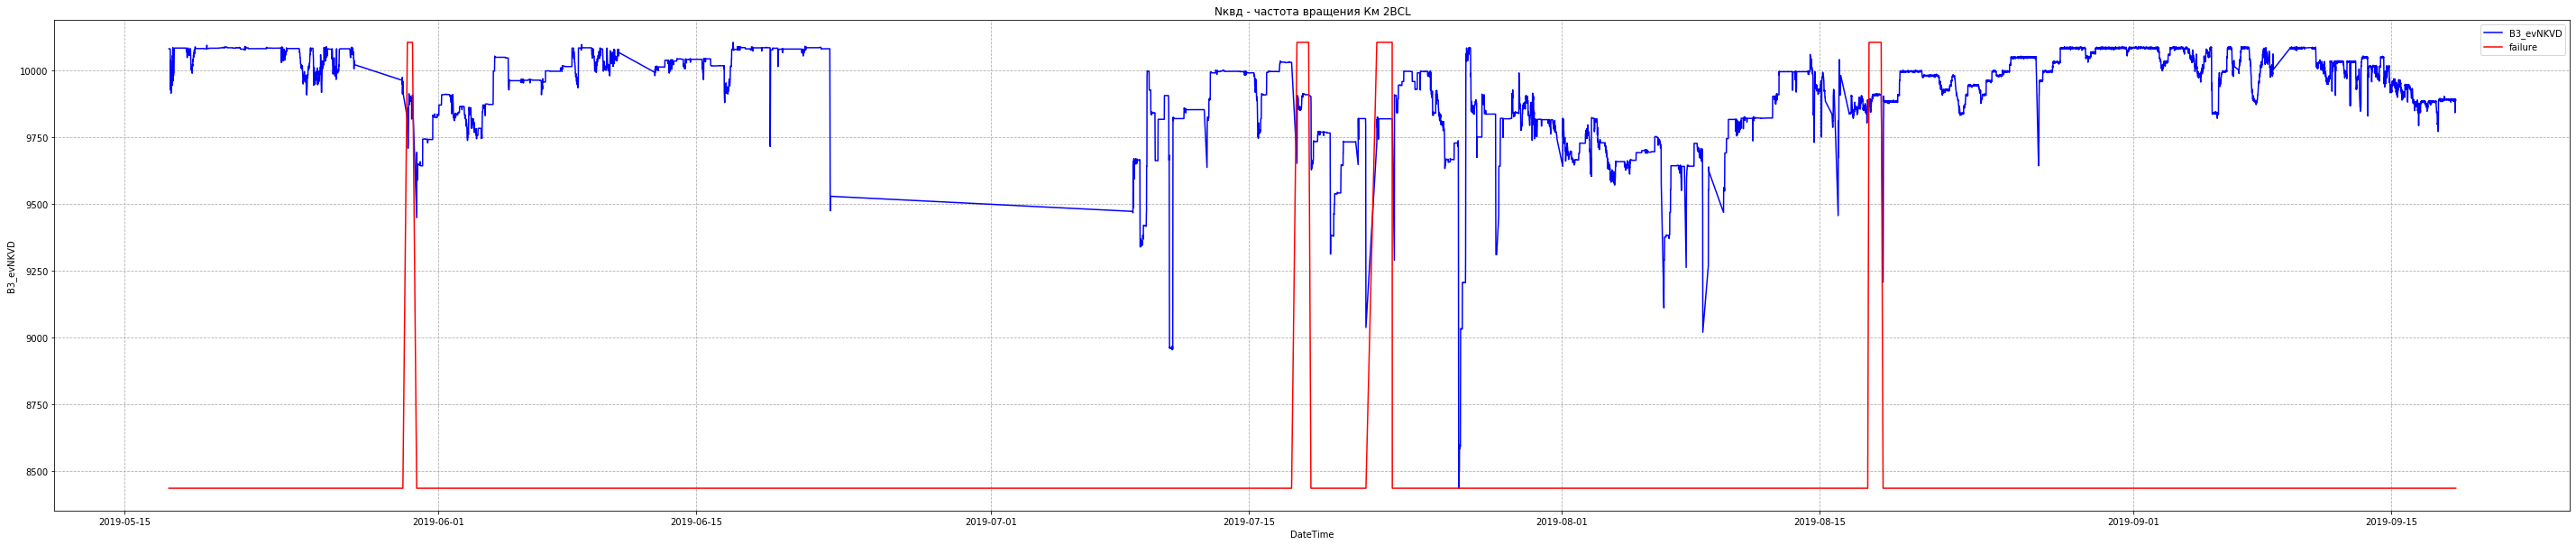

In [21]:
for col in features:

    min_col = min(data[col])
    max_col = max(data[col])
    flr_data = data[not_features]
    flr_data.loc[flr_data['y']==0, 'y'] = min_col
    flr_data.loc[flr_data['y']==1, 'y'] = max_col
    
    plt.figure(figsize=(50,10)) 
    
    desc_idx = headers.loc[headers['field']==col].index[0]
    desc = headers.values[desc_idx][1]     
    plt.title(desc)
    
    plt.grid(True, linestyle='--')
    #plt.tick_params(labelsize=20)
    
    plt.xlabel('DateTime')
    plt.ylabel(col)
    plt.plot(data['DateTime'], data[col], label=col, color='blue')
    plt.plot(data['DateTime'], flr_data['y'], label='failure', color='red')
    
    plt.legend(loc=0)
    plt.show()

Вывод:
1. По графикам визуально оценить зависимость отказов оборудования от показаний датчиков не удается.

### Попарная корреляция параметров в рамках групп

Группы параметров:
1. 'B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2'
2. 'B3_PDIT561', 'B3_PDIT571'
3. 'B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573'
4. 'B3_T_C5', 'B3_T_C6'
5. 'B3_Tg_inKVD1', 'B3_Tg_inKVD2', 'B3_Tg_outKVD1', 'B3_Tg_outKVD2'
6. 'B3_TIT561', 'B3_TIT571'
7. 'B3_E_BCL', 'B3_E_Cm', 'B3_E_MCL', 'B3_E_Ras1', 'B3_E_Ras2'
8. 'B3_evNKVD'

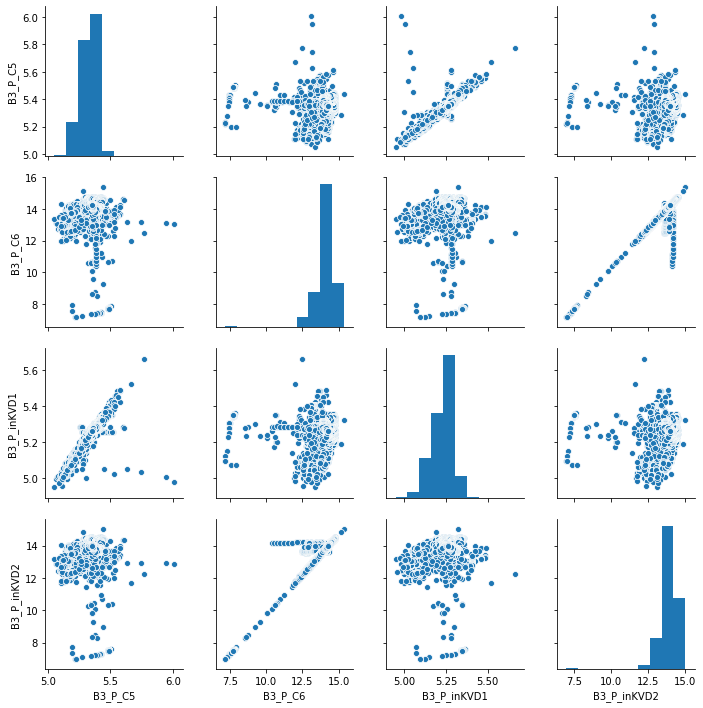

In [14]:
sns_plot = sns.pairplot(data[['B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2']])
sns_plot.savefig('pairplot.png')

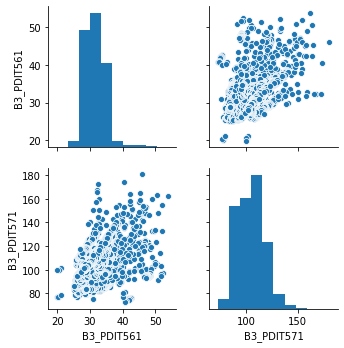

In [15]:
sns_plot = sns.pairplot(data[['B3_PDIT561', 'B3_PDIT571']])
sns_plot.savefig('pairplot.png')

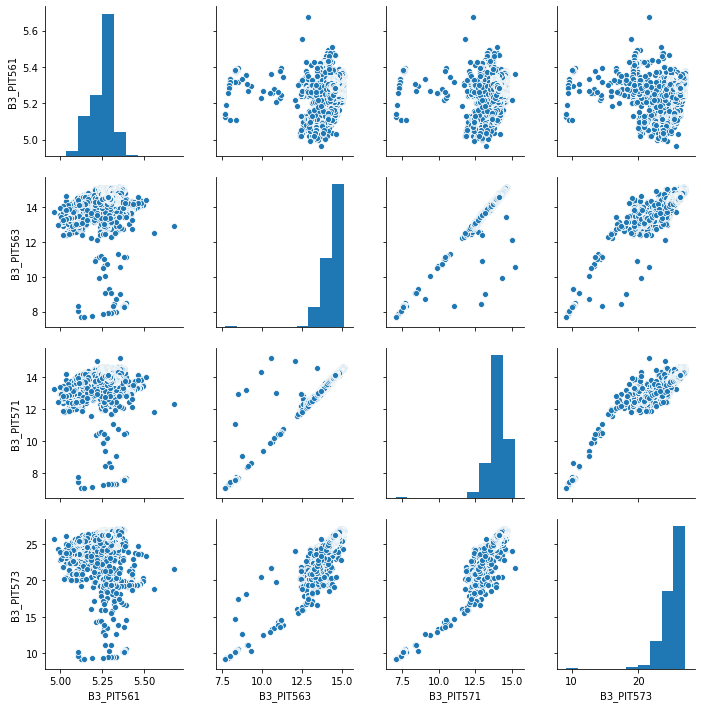

In [16]:
sns_plot = sns.pairplot(data[['B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573']])
sns_plot.savefig('pairplot.png')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


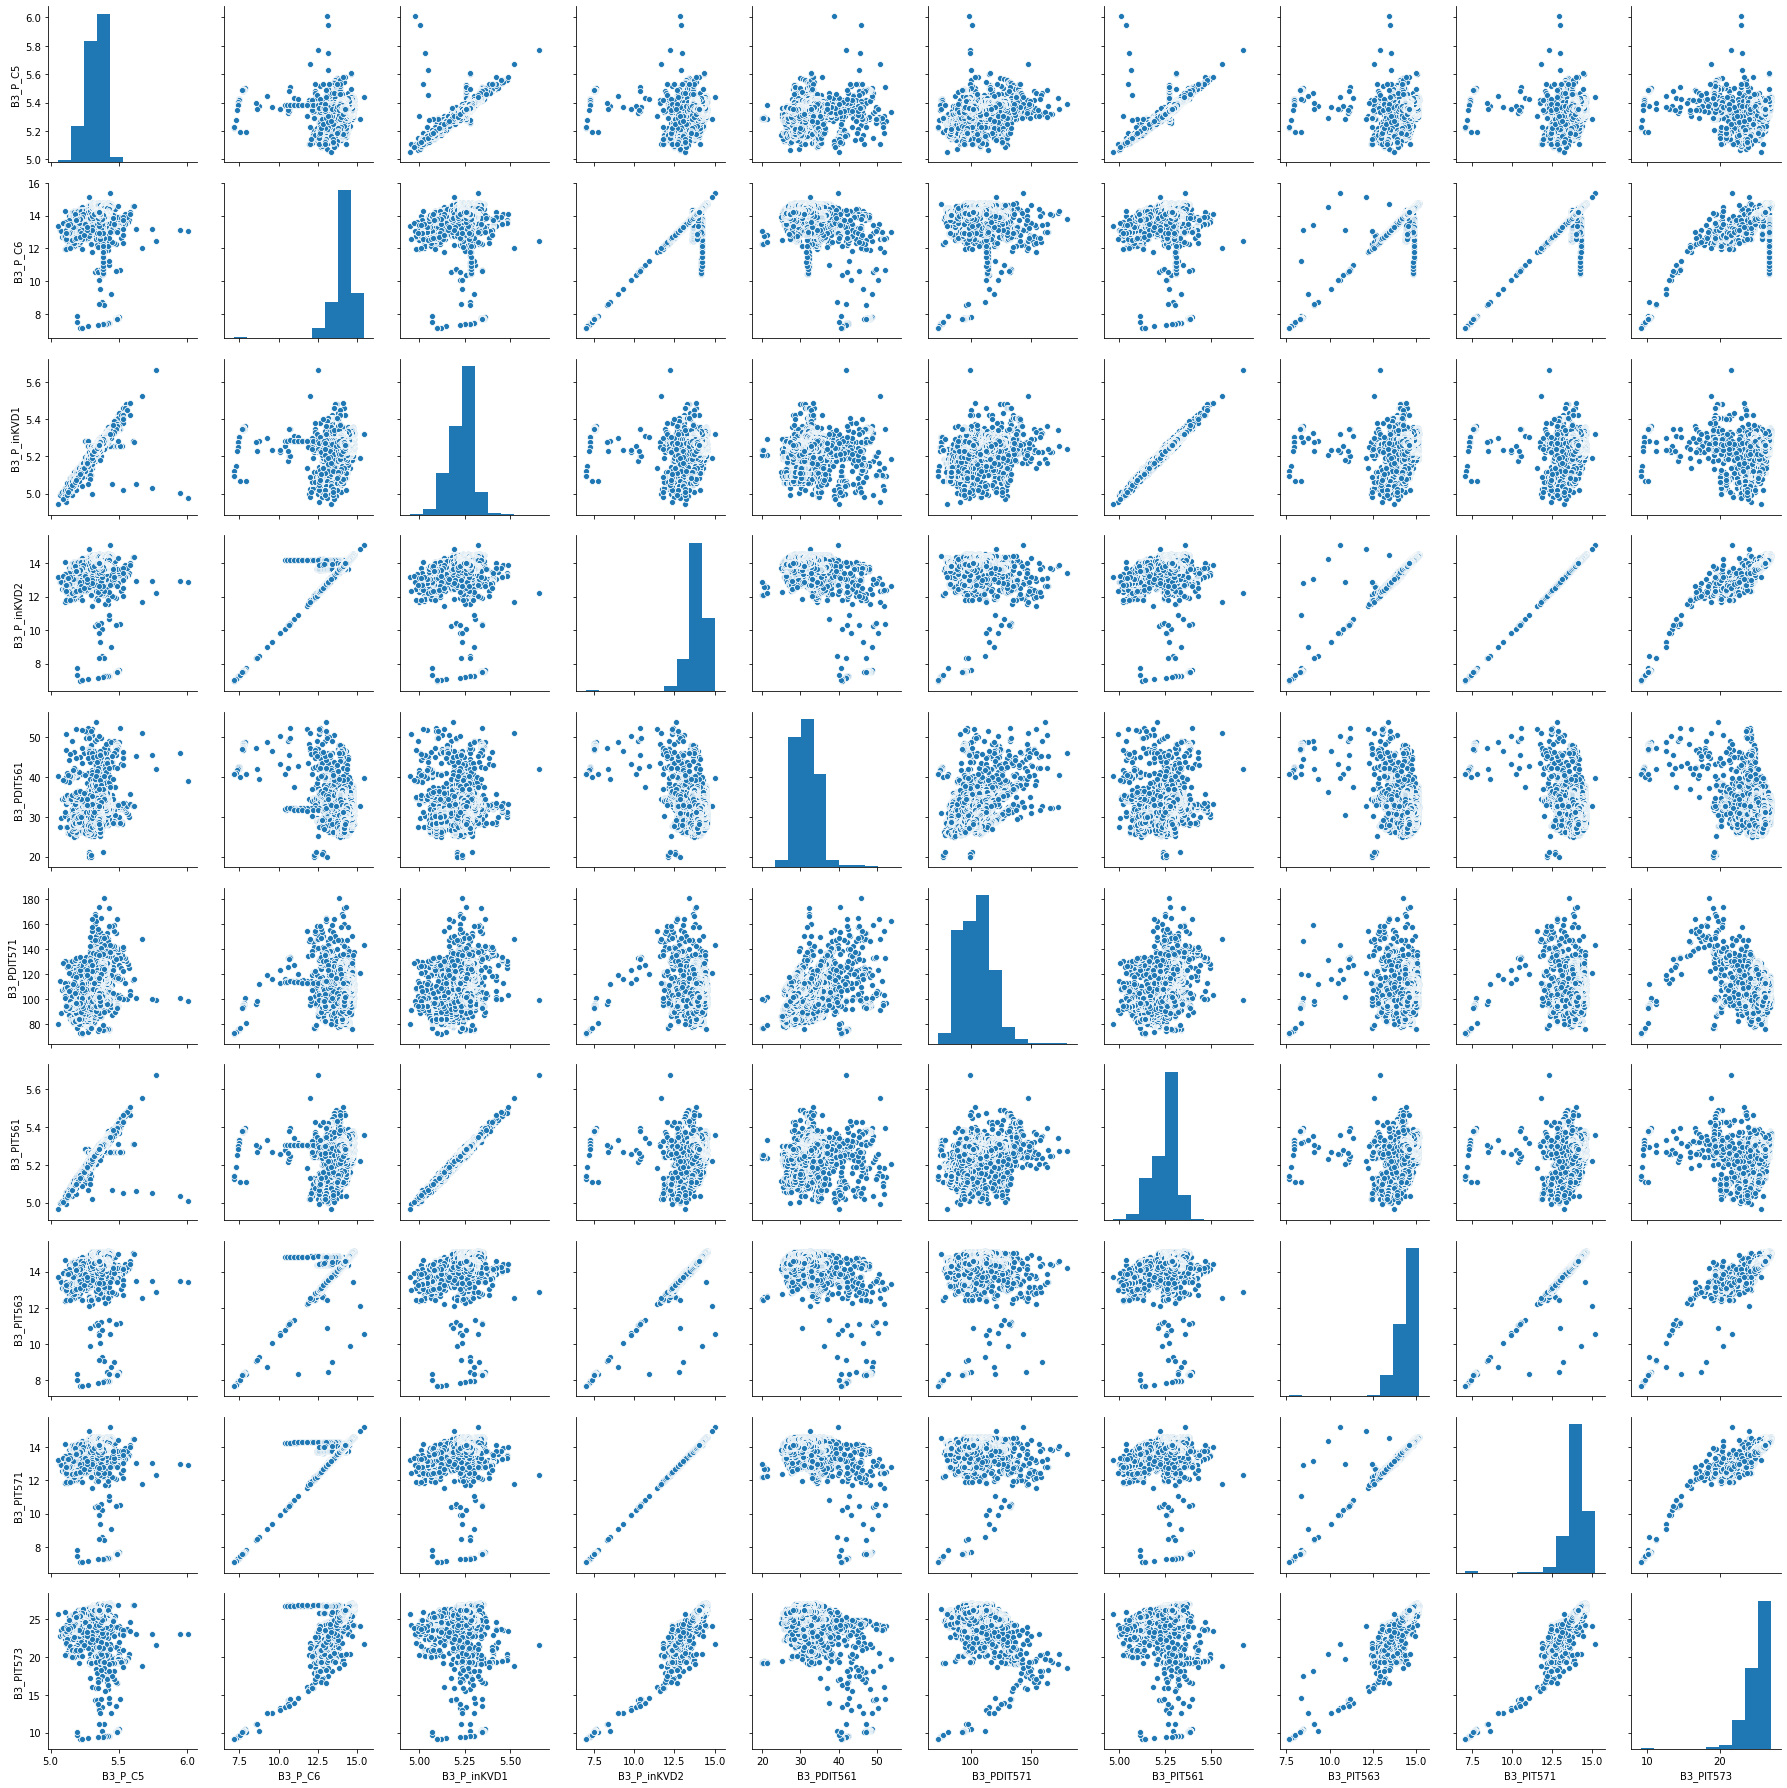

In [23]:
sns_plot = sns.pairplot(data[['B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2', 'B3_PDIT561', 'B3_PDIT571', 'B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573']])
sns_plot.savefig('pairplot.png')

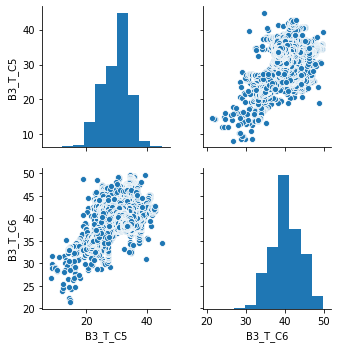

In [17]:
sns_plot = sns.pairplot(data[['B3_T_C5', 'B3_T_C6']])
sns_plot.savefig('pairplot.png')

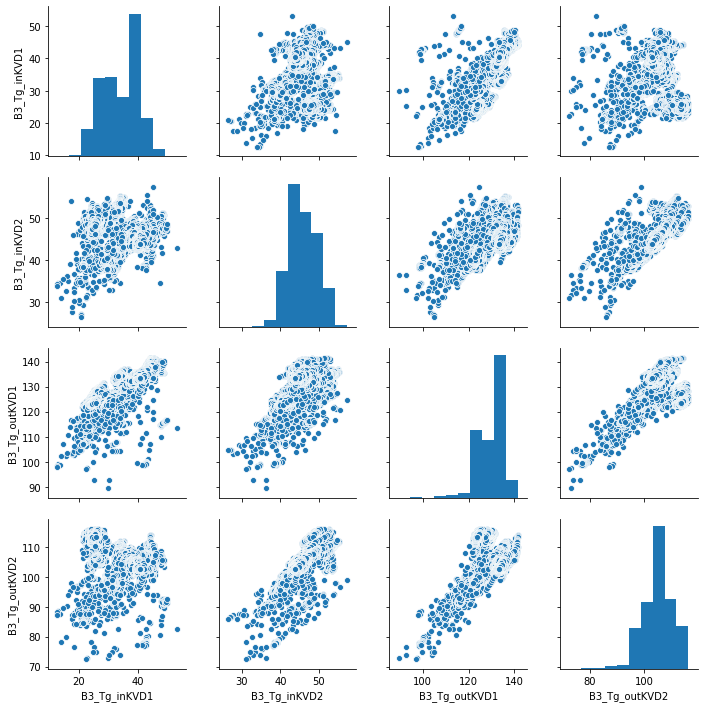

In [18]:
sns_plot = sns.pairplot(data[['B3_Tg_inKVD1', 'B3_Tg_inKVD2', 'B3_Tg_outKVD1', 'B3_Tg_outKVD2']])
sns_plot.savefig('pairplot.png')

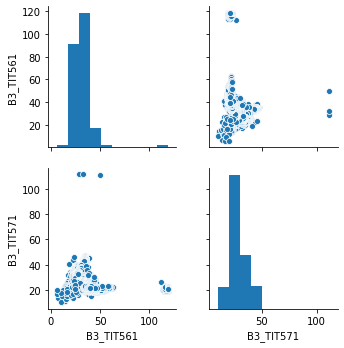

In [19]:
sns_plot = sns.pairplot(data[['B3_TIT561', 'B3_TIT571']])
sns_plot.savefig('pairplot.png')

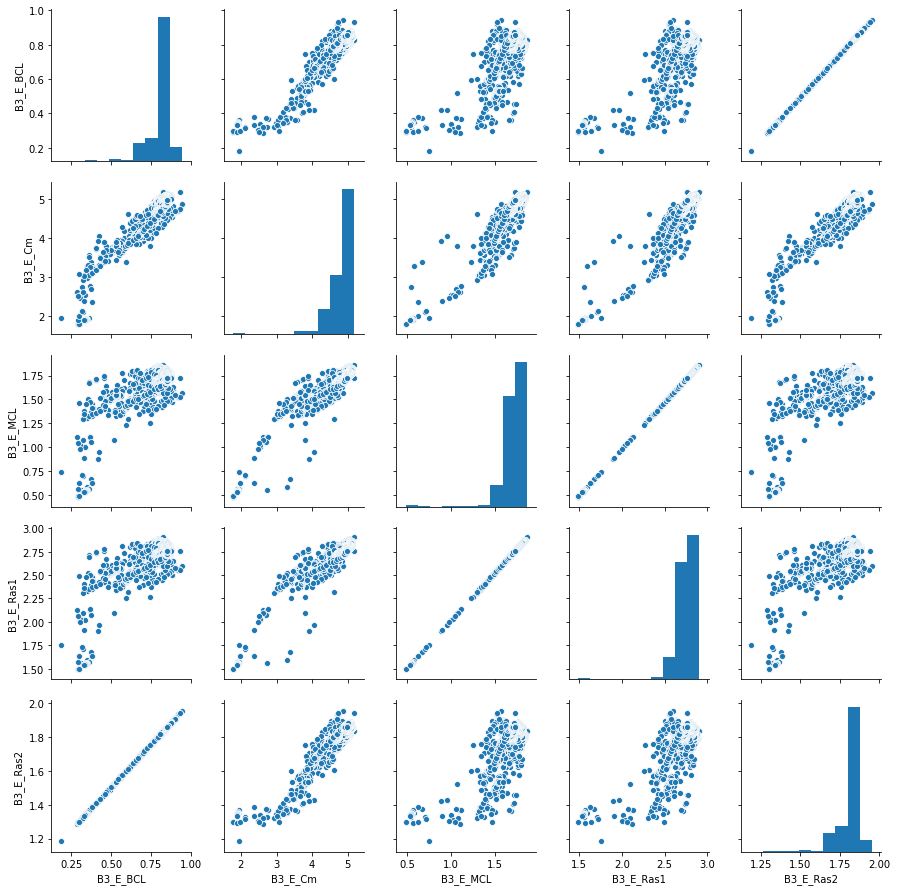

In [20]:
sns_plot = sns.pairplot(data[['B3_E_BCL', 'B3_E_Cm', 'B3_E_MCL', 'B3_E_Ras1', 'B3_E_Ras2']])
sns_plot.savefig('pairplot.png')

## Feature engineering

### Заполнение пропусков в числовых данных

In [160]:
data.columns

Index(['DateTime', 'B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2',
       'B3_PDIT561', 'B3_PDIT571', 'B3_PIT561', 'B3_PIT563', 'B3_PIT571',
       'B3_PIT573', 'B3_T_C5', 'B3_T_C6', 'B3_Tg_inKVD1', 'B3_Tg_inKVD2',
       'B3_Tg_outKVD1', 'B3_Tg_outKVD2', 'B3_TIT561', 'B3_TIT571', 'B3_E_BCL',
       'B3_E_Cm', 'B3_E_MCL', 'B3_E_Ras1', 'B3_E_Ras2', 'B3_evNKVD', 'y'],
      dtype='object')

In [11]:
#Расчет медиан для каждого атрибута по группам в зависимости от целевого столбца

not_features = ['DateTime', 'y'] #Столбцы, не являющиеся атрибутами
#median_values = pd.DataFrame(columns = ['col', 'median_y0', 'median_y1'])

for col in data.loc[:, ~data.columns.isin(not_features)].columns:
    median_y0 = data[col].loc[~pd.isnull(data[col])].loc[data['y']==0].median()
    median_y1 = data[col].loc[~pd.isnull(data[col])].loc[data['y']==1].median()
    
    '''
    median_values = median_values.append(pd.DataFrame([[col, median_y0, median_y1]],
                                                        columns = ['col', 'median_y0', 'median_y1']),
                                                        ignore_index=True)
    '''
    
    #замена пустого значения на медиану
    #data[col].fillna(median_y0, inplace=True) #нельзя применить условие, не подходит
    data.loc[(pd.isnull(data[col])) & (data['y']==0), col] = median_y0
    data.loc[(pd.isnull(data[col])) & (data['y']==1), col] = median_y1

#median_values

### Разделение на обучающую и тестовую выборки

In [12]:
feature_list = data.loc[:, ~data.columns.isin(not_features)]
target = data['y']

X_train, X_test, Y_train, Y_test = train_test_split(feature_list, target, test_size=0.3, random_state=None)

In [13]:
columns = X_train.columns

### Нормирование значений атрибутов

In [217]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [218]:
X_train_imputed_scaled = scaler.transform(X_train)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [219]:
X_test_imputed_scaled = scaler.transform(X_test)

In [220]:
X_train = X_train_imputed_scaled
X_test = X_test_imputed_scaled

## Обучение модели

In [21]:
model = LogisticRegression(max_iter=5000, n_jobs=-1)
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Предсказание

In [35]:
predictions = model.predict_proba(X_test)

In [36]:
model.score(X_train, Y_train)

0.97482088024565

In [37]:
model.score(X_test, Y_test)

0.9751671442215855

## Оценка качества модели

### Матрица ошибок

In [58]:
def confusion_matrix(predictions, Y_test):
    '''
    Функция генерации матрицы ошибок.
    На вход подаются предсказанные значения целевой переменной и реальные значения.
    '''
       
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative

    for predicted_prob, actual in zip(predictions[:, 1], Y_test):
        if predicted_prob > 0.5:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    
    #Расчет метрик качества
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    true_positive_rate = tp / (tp + fn)
    false_positive_rate = fp / (fp + tn)
            
    #Матрица ошибок
    print('--------------------------------------------')
    print('Confusion Matrix')
    print('--------------------------------------------')
    print('                  ', 'Actual positive', 'Actual negative')
    print('Predicted positive      ', tp,'             ', fp) 
    print('Predicted negative      ', fn,'             ', tn)
    print('--------------------------------------------')
    print('Total observations: ', tp+fn+fp+tn)
    print('Accuracy:            {:.2%}'.format(accuracy))
    print()
    print('True positive:      ', tp)
    print('True negative:      ', tn)
    print('False positive:     ', fp)
    print('False negative:     ', fn)
    print()
    print('True positive rate:  {:.2%}'.format(true_positive_rate))
    print('False positive rate: {:.2%}'.format(false_positive_rate))
    print()
    print('Recall:              {:.2%}'.format(recall))
    print('Precision:           {:.2%}'.format(precision))
    print('--------------------------------------------')

In [52]:
confusion_matrix(predictions, Y_test)

--------------------------------------------
Confusion Matrix
--------------------------------------------
                   Actual positive Actual negative
Predicted positive       4               4
Predicted negative       100               4080
--------------------------------------------
Total observations:  4188
Accuracy:            97.52%

True positive:       4
True negative:       4080
False positive:      4
False negative:      100

True positive rate:  3.85%
False positive rate: 0.10%

Recall:              3.85%
Precision:           50.00%
--------------------------------------------


### Precision-Recall

In [29]:
pr, re, thres = precision_recall_curve(Y_test, predictions[:, 1])

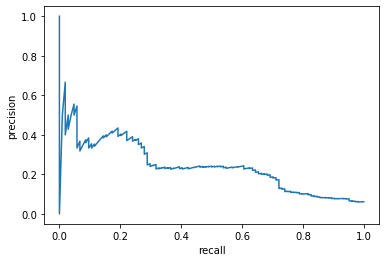

In [30]:
plt.xlabel('recall')
plt.ylabel('precision')

plt.plot(re, pr)

### ROC-AUC

In [31]:
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )

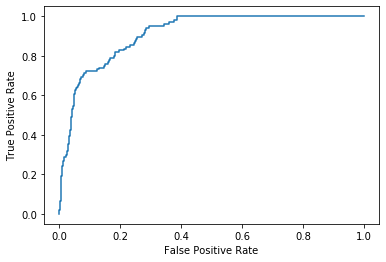

In [32]:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(fpr, tpr)

In [33]:
roc_auc_score(Y_test, predictions[:, 1])

0.9118676071724554

In [34]:
auc(fpr, tpr)

0.9118676071724554